In [1]:
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
%matplotlib inline
import matplotlib.pyplot as plt
import pickle


In [9]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'LUV':
        return  cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HLS':
        return  cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



In [10]:
def extract_single_image_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    file_features = []
    
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
        
    return file_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        
        #print('image shape ', image.shape)
        
        file_features = extract_single_image_features(image, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)

        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [ ]:
# Trial run to check extract_features
import glob
image_filenames = glob.glob('test_images/test*.jpg')
#plt.imshow(image)

features = extract_features(image_filenames, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True)

print('features.shape ', len(features))
print('features[0].shape ', features[0].shape)

img.shape  (64, 64, 3)


True

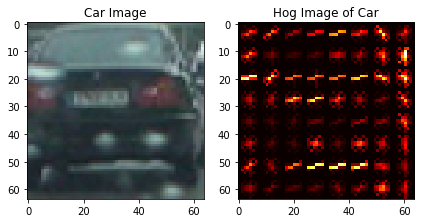

In [16]:
# Trial run to check hog extraction

img = mpimg.imread('test_images/image0401.png')

hls_img = convert_color(img, conv = 'HLS')

print('img.shape ', img.shape)
orient = 9
pix_per_cell= 8
cell_per_block= 2

#hog_features = []
#for channel in range(feature_image.shape[2]):
#    hog_features.append(get_hog_features(feature_image[:,:,channel], 
#                        orient, pix_per_cell, cell_per_block, 
#                        vis=False, feature_vec=True))
#hog_features = np.ravel(hog_features)

features, hog_image = get_hog_features(img[:,:,2], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
fig = plt.figure()
plt.subplot(121)
plt.imshow(img)
plt.title('Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='hot')
plt.title('Hog Image of Car')
fig.tight_layout()

cv2.imwrite('output_images/hog_image0401.png', hog_image)

In [4]:
from sklearn.cross_validation import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

def train(cars, notcars, cars_sample_size, not_cars_sample_size, color_space='YUV', 
                            spatial_size=(16,16), hist_bins=16, 
                            orient=9, pix_per_cell=8, 
                            cell_per_block=2, 
                            hog_channel='ALL', spatial_feat=True, 
                            hist_feat=True, hog_feat=True):
    print('no. of not car images is ', len(notcars))
    print('no. of car images is ', len(cars))

    cars = cars[0:cars_sample_size]
    notcars = notcars[0:not_cars_sample_size]

    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)

    print('X_train shape', X_train.shape)
    print('X_test shape', X_test.shape)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    accuracy_score = round(svc.score(X_test, y_test), 4)
    print('Test Accuracy of SVC = ', accuracy_score)
    # Check the prediction time for a single sample
    t=time.time()

    return svc, X_scaler, accuracy_score


#notcars = glob.glob('../CarND-Vehicle-Detection-Data/non-vehicles/**/*.png')
#cars = glob.glob('../CarND-Vehicle-Detection-Data/vehicles/**/*.png')

#svc, X_scaler, accuracy_score = train(cars, notcars, len(cars)-1, len(notcars)-1)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    print('spatial_size ', spatial_size)
    print('hist ', hist_bins)
    print('orient ', orient)
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        #print('imshape ', imshape)
        #print('ctrans_tosearch ', ctrans_tosearch)
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]


    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
        
    #print('ch1.shape[1] ', ch1.shape[1])
    #print('pix_per_cell ', pix_per_cell)
    #print('(ch1.shape[1] // pix_per_cell) ', (ch1.shape[1] // pix_per_cell))
    #print('cell_per_block ', cell_per_block)
    #print('nxblocks ', nxblocks)
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    rectangles = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            #print('spatial_features.shape ', spatial_features.shape)
            #print('hist_features.shape ', hist_features.shape )
            #print('hog_features.shape ', hog_features.shape)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features)).reshape(1, -1))    
            hstack_features=np.hstack((spatial_features, hist_features, hog_features))
            test_features = X_scaler.transform(hstack_features).reshape(1, -1)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
     
    print('no. of rectangles found is ', len(rectangles))
    return rectangles


In [6]:
# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

In [7]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


spatial_size  (16, 16)
hist  16
orient  9


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Resha

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Resha

no. of rectangles found is  84
spatial_size  (16, 16)
hist  16
orient  9


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Resha

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Resha

no. of rectangles found is  44


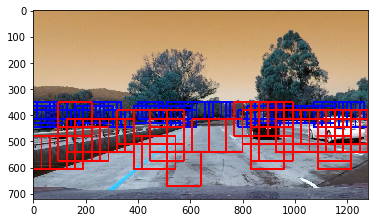

In [12]:
# Trial run to check the impact due to scale and other parameters

#test_image = mpimg.imread('test_images/test5.jpg')
#test_image = mpimg.imread('../CarND-Vehicle-Detection-Data/vehicles/GTI_Far/image0201.png')
test_image = mpimg.imread('output_images/input_image0.jpg')


#plt.imshow(test_image)

scale = 1
ystart=350
ystop=450
rectangles_1 = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

scale = 2
ystart=350
ystop=680
rectangles_2 = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

#scale = 3
#rectangles_3 = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)


image_with_boxes = np.copy(test_image)
image_with_boxes = draw_boxes(image_with_boxes, rectangles_1, color = (0,0,255))
image_with_boxes = draw_boxes(image_with_boxes, rectangles_2, color = (255,0,0))
#image_with_boxes = draw_boxes(image_with_boxes, rectangles_3, color = (0,255,0))

plt.imshow(image_with_boxes)

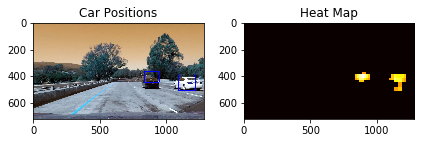

In [17]:
# Trial run to see the impact due to heat threshold

from scipy.ndimage.measurements import label

heat = np.zeros_like(test_image[:,:,0]).astype(np.float)


# Add heat to each box in box list
heat = add_heat(heat,rectangles_1)
heat = add_heat(heat,rectangles_2)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,8)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


In [8]:
# Tune the parameters here

color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations  e.g.: 9
pix_per_cell = 8 # HOG pixels per cell e.g: 8
cell_per_block = 2 # HOG cells per block e.g: 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions e.g: (16,16)
hist_bins = 16    # Number of histogram bins e.g: 16
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()


# find_cars parameters
ystart = 400
ystop = 680
scale = 1.5



In [ ]:
import pickle
import time

notcars = glob.glob('../CarND-Vehicle-Detection-Data/non-vehicles/**/*.png')
cars = glob.glob('../CarND-Vehicle-Detection-Data/vehicles/**/*.png')


# No. of samples to consider for training
cars_sample_size = len(cars)-1
not_cars_sample_size=len(notcars)-1

#cars_sample_size = 8700
#not_cars_sample_size = 8700

t=time.time()

svc, X_scaler, accuracy_score = train(cars, notcars, 
                            cars_sample_size = cars_sample_size, not_cars_sample_size=not_cars_sample_size,
                            color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

print('count of cars : ', cars_sample_size, ', count of not-cars : ', not_cars_sample_size)
print('color_space | orient | pix_per_cell | cell_per_block | hog_channel | spatial_size | hist_bins | Execution Time | Validation Accuracy |')
print(color_space, '|', orient , '|', pix_per_cell , '|', cell_per_block , '|', hog_channel , '|', spatial_size , '|', hist_bins, '|', round(t2-t, 2), '|', accuracy_score, '|')


vehicle_detector = { "svc": svc, "X_scaler": X_scaler }

with open('data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(vehicle_detector, f, pickle.HIGHEST_PROTOCOL)

In [9]:
from scipy.ndimage.measurements import label


vehicle_detector = {}

with open('data.pickle', 'rb') as f:
    vehicle_detector = pickle.load(f)

svc = vehicle_detector["svc"]
X_scaler = vehicle_detector["X_scaler"]



input_image_filename  output_images/input_image0.jpg
output_image_filename  output_images/output_image0.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Resha

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Resha

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Resha

no. of rectangles found is  18
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  13 , rectangles_2 count :  18 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1.jpg
output_image_filename  output_images/output_image1.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Resha

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Resha

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Resha

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)


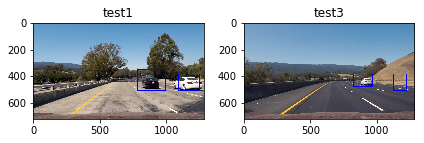

In [10]:
#import functools.reduce

class HeatMapHistory():
    def __init__(self):
        self.history=[]
    
heatMapHistory = HeatMapHistory()

image_count = 0
snapshot_needed = False

def pipeline(image, frames_to_track = 4):
    
    global image_count, snapshot_needed
    
    input_image_filename = 'output_images/input_image' + str(image_count) + '.jpg'
    output_image_with_boxes_filename = 'output_images/output_image_with_boxes_image' + str(image_count) + '.jpg'
    output_image_avg_heatmap_history_filename = 'output_images/output_image_avg_heatmap_history_image' + str(image_count) + '.jpg'
    output_image_threshold_applied_filename = 'output_images/output_image_threshold_applied_image' + str(image_count) + '.jpg'
    output_image_filename = 'output_images/output_image' + str(image_count) + '.jpg'
    image_count = image_count + 1
    
    print('input_image_filename ', input_image_filename)
    print('output_image_filename ', output_image_filename)

    if(snapshot_needed):
        cv2.imwrite(input_image_filename, image)
    print('input image is written successfully')
    
#    rectangles = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    scale = 1
    ystart=350
    ystop=450
    rectangles_1 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    scale = 2
    ystart=350
    ystop=550
    rectangles_2 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    scale = 3
    ystart=500
    ystop=680
    rectangles_3 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)


    print('rectangles_1 count : ', len(rectangles_1), ', rectangles_2 count : ', len(rectangles_2), ', rectangles_3 count : ', len(rectangles_3))

    if(snapshot_needed):
        image_with_boxes = np.copy(image)
        image_with_boxes = draw_boxes(image_with_boxes, rectangles_1, color = (0,0,255))
        image_with_boxes = draw_boxes(image_with_boxes, rectangles_2, color = (255,0,0))
        image_with_boxes = draw_boxes(image_with_boxes, rectangles_3, color = (0,255,0))
        cv2.imwrite(output_image_with_boxes_filename, image_with_boxes)
    
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    #heat = add_heat(heat,rectangles)
    heatmap = add_heat(heatmap,rectangles_1)
    heatmap = add_heat(heatmap,rectangles_2)
    heatmap = add_heat(heatmap,rectangles_3)
    
    if(len(heatMapHistory.history) > frames_to_track):
        heatMapHistory.history = heatMapHistory.history[1:]
        
    heatMapHistory.history.append(heatmap)
    
    totalHeatMapHistory = np.zeros_like(image[:,:,0]).astype(np.float)
    for hm in heatMapHistory.history:
        totalHeatMapHistory = totalHeatMapHistory + hm
    
    if(len(heatMapHistory.history) < frames_to_track):
        #print('totalHeatMapHistory ', totalHeatMapHistory)
        average_heatmap_history = totalHeatMapHistory/len(heatMapHistory.history)
        #print('average_heatmap_history ', average_heatmap_history)
    else:
        average_heatmap_history = totalHeatMapHistory/frames_to_track
        
    print('totalHeatMapHistory.shape ', totalHeatMapHistory.shape)
    
    if(snapshot_needed):
        cv2.imwrite(output_image_avg_heatmap_history_filename, average_heatmap_history)
    
    # Apply threshold to help remove false positives
    heatmap = apply_threshold(average_heatmap_history,3)
    
    if(snapshot_needed):
        cv2.imwrite(output_image_threshold_applied_filename, heatmap)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heatmap, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    if(snapshot_needed):
        cv2.imwrite(output_image_filename, draw_img)

    return draw_img
    
    
    

draw_img_1 = pipeline(mpimg.imread('test_images/test1.jpg'))
draw_img_2 = pipeline(mpimg.imread('test_images/test3.jpg'))
#plt.imshow(draw_img)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img_1)
plt.title('test1')
plt.subplot(122)
plt.imshow(draw_img_2)
plt.title('test3')
fig.tight_layout()

In [11]:

# Import everything needed to edit/save/watch video clips# Import 
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Test the pipeline on the test video

#input_video = 'test_video.mp4'
#output_video = 'vehicles_tracked_on_test_video.mp4'
#clip = VideoFileClip(input_video)

input_video = 'project_video.mp4'
output_video = 'vehicles_tracked_on_project_video.mp4'
clip = VideoFileClip(input_video)


#clip = VideoFileClip('test_video.mp4').subclip(1,2)
yellow_clip = clip.fl_image(pipeline)
%time yellow_clip.write_videofile(output_video, audio=False)

input_image_filename  output_images/input_image2.jpg
output_image_filename  output_images/output_image2.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
[MoviePy] >>>> Building video vehicles_tracked_on_project_video.mp4
[MoviePy] Writing video vehicles_tracked_on_project_video.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

input_image_filename  output_images/input_image3.jpg
output_image_filename  output_images/output_image3.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


  0%|          | 1/1261 [00:01<21:48,  1.04s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image4.jpg
output_image_filename  output_images/output_image4.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


  0%|          | 2/1261 [00:02<21:30,  1.03s/it]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image5.jpg
output_image_filename  output_images/output_image5.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


  0%|          | 3/1261 [00:03<21:17,  1.02s/it]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image6.jpg
output_image_filename  output_images/output_image6.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9


  0%|          | 4/1261 [00:04<21:01,  1.00s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  16 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image7.jpg
output_image_filename  output_images/output_image7.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9


  0%|          | 5/1261 [00:04<20:40,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  13 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image8.jpg
output_image_filename  output_images/output_image8.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


  0%|          | 6/1261 [00:06<21:02,  1.01s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image9.jpg
output_image_filename  output_images/output_image9.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


  1%|          | 7/1261 [00:06<20:57,  1.00s/it]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image10.jpg
output_image_filename  output_images/output_image10.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


  1%|          | 8/1261 [00:07<20:44,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image11.jpg
output_image_filename  output_images/output_image11.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


  1%|          | 9/1261 [00:08<20:45,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image12.jpg
output_image_filename  output_images/output_image12.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


  1%|          | 10/1261 [00:09<20:38,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image13.jpg
output_image_filename  output_images/output_image13.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


  1%|          | 11/1261 [00:10<20:29,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image14.jpg
output_image_filename  output_images/output_image14.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


  1%|          | 12/1261 [00:11<20:12,  1.03it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image15.jpg
output_image_filename  output_images/output_image15.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


  1%|          | 13/1261 [00:12<20:05,  1.03it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image16.jpg
output_image_filename  output_images/output_image16.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


  1%|          | 14/1261 [00:13<20:02,  1.04it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image17.jpg
output_image_filename  output_images/output_image17.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


  1%|          | 15/1261 [00:14<19:55,  1.04it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image18.jpg
output_image_filename  output_images/output_image18.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


  1%|▏         | 16/1261 [00:15<19:55,  1.04it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image19.jpg
output_image_filename  output_images/output_image19.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


  1%|▏         | 17/1261 [00:16<20:04,  1.03it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image20.jpg
output_image_filename  output_images/output_image20.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


  1%|▏         | 18/1261 [00:17<20:06,  1.03it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image21.jpg
output_image_filename  output_images/output_image21.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


  2%|▏         | 19/1261 [00:18<20:07,  1.03it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image22.jpg
output_image_filename  output_images/output_image22.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


  2%|▏         | 20/1261 [00:19<20:12,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image23.jpg
output_image_filename  output_images/output_image23.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


  2%|▏         | 21/1261 [00:20<20:12,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image24.jpg
output_image_filename  output_images/output_image24.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


  2%|▏         | 22/1261 [00:21<20:13,  1.02it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image25.jpg
output_image_filename  output_images/output_image25.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


  2%|▏         | 23/1261 [00:22<20:15,  1.02it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image26.jpg
output_image_filename  output_images/output_image26.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


  2%|▏         | 24/1261 [00:23<20:03,  1.03it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image27.jpg
output_image_filename  output_images/output_image27.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


  2%|▏         | 25/1261 [00:24<20:09,  1.02it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image28.jpg
output_image_filename  output_images/output_image28.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


  2%|▏         | 26/1261 [00:25<20:09,  1.02it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image29.jpg
output_image_filename  output_images/output_image29.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


  2%|▏         | 27/1261 [00:26<20:07,  1.02it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image30.jpg
output_image_filename  output_images/output_image30.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


  2%|▏         | 28/1261 [00:27<20:06,  1.02it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image31.jpg
output_image_filename  output_images/output_image31.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


  2%|▏         | 29/1261 [00:28<20:04,  1.02it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image32.jpg
output_image_filename  output_images/output_image32.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


  2%|▏         | 30/1261 [00:29<20:07,  1.02it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image33.jpg
output_image_filename  output_images/output_image33.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


  2%|▏         | 31/1261 [00:30<20:13,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image34.jpg
output_image_filename  output_images/output_image34.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


  3%|▎         | 32/1261 [00:31<20:11,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image35.jpg
output_image_filename  output_images/output_image35.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


  3%|▎         | 33/1261 [00:32<20:06,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image36.jpg
output_image_filename  output_images/output_image36.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


  3%|▎         | 34/1261 [00:33<20:41,  1.01s/it]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image37.jpg
output_image_filename  output_images/output_image37.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


  3%|▎         | 35/1261 [00:34<20:48,  1.02s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image38.jpg
output_image_filename  output_images/output_image38.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


  3%|▎         | 36/1261 [00:35<20:36,  1.01s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image39.jpg
output_image_filename  output_images/output_image39.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


  3%|▎         | 37/1261 [00:36<20:29,  1.00s/it]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image40.jpg
output_image_filename  output_images/output_image40.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


  3%|▎         | 38/1261 [00:37<20:22,  1.00it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image41.jpg
output_image_filename  output_images/output_image41.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


  3%|▎         | 39/1261 [00:38<20:17,  1.00it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image42.jpg
output_image_filename  output_images/output_image42.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


  3%|▎         | 40/1261 [00:39<20:13,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image43.jpg
output_image_filename  output_images/output_image43.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


  3%|▎         | 41/1261 [00:40<20:08,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image44.jpg
output_image_filename  output_images/output_image44.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


  3%|▎         | 42/1261 [00:41<20:06,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image45.jpg
output_image_filename  output_images/output_image45.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


  3%|▎         | 43/1261 [00:42<20:13,  1.00it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image46.jpg
output_image_filename  output_images/output_image46.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


  3%|▎         | 44/1261 [00:43<20:09,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image47.jpg
output_image_filename  output_images/output_image47.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


  4%|▎         | 45/1261 [00:44<20:10,  1.00it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image48.jpg
output_image_filename  output_images/output_image48.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


  4%|▎         | 46/1261 [00:45<20:08,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image49.jpg
output_image_filename  output_images/output_image49.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


  4%|▎         | 47/1261 [00:46<20:03,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image50.jpg
output_image_filename  output_images/output_image50.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


  4%|▍         | 48/1261 [00:47<20:21,  1.01s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image51.jpg
output_image_filename  output_images/output_image51.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


  4%|▍         | 49/1261 [00:48<20:23,  1.01s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image52.jpg
output_image_filename  output_images/output_image52.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


  4%|▍         | 50/1261 [00:49<20:15,  1.00s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image53.jpg
output_image_filename  output_images/output_image53.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


  4%|▍         | 51/1261 [00:50<20:09,  1.00it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image54.jpg
output_image_filename  output_images/output_image54.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


  4%|▍         | 52/1261 [00:51<20:04,  1.00it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image55.jpg
output_image_filename  output_images/output_image55.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


  4%|▍         | 53/1261 [00:52<20:24,  1.01s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image56.jpg
output_image_filename  output_images/output_image56.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


  4%|▍         | 54/1261 [00:53<20:12,  1.00s/it]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image57.jpg
output_image_filename  output_images/output_image57.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


  4%|▍         | 55/1261 [00:54<20:07,  1.00s/it]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image58.jpg
output_image_filename  output_images/output_image58.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


  4%|▍         | 56/1261 [00:55<20:11,  1.01s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image59.jpg
output_image_filename  output_images/output_image59.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


  5%|▍         | 57/1261 [00:56<20:03,  1.00it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image60.jpg
output_image_filename  output_images/output_image60.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


  5%|▍         | 58/1261 [00:57<19:56,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image61.jpg
output_image_filename  output_images/output_image61.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


  5%|▍         | 59/1261 [00:58<19:51,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image62.jpg
output_image_filename  output_images/output_image62.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


  5%|▍         | 60/1261 [00:59<19:47,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image63.jpg
output_image_filename  output_images/output_image63.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


  5%|▍         | 61/1261 [01:00<19:50,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image64.jpg
output_image_filename  output_images/output_image64.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


  5%|▍         | 62/1261 [01:01<19:45,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image65.jpg
output_image_filename  output_images/output_image65.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


  5%|▍         | 63/1261 [01:02<19:45,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image66.jpg
output_image_filename  output_images/output_image66.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


  5%|▌         | 64/1261 [01:03<19:42,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image67.jpg
output_image_filename  output_images/output_image67.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


  5%|▌         | 65/1261 [01:04<19:45,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image68.jpg
output_image_filename  output_images/output_image68.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


  5%|▌         | 66/1261 [01:05<19:59,  1.00s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image69.jpg
output_image_filename  output_images/output_image69.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


  5%|▌         | 67/1261 [01:06<19:57,  1.00s/it]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image70.jpg
output_image_filename  output_images/output_image70.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


  5%|▌         | 68/1261 [01:07<19:50,  1.00it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image71.jpg
output_image_filename  output_images/output_image71.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


  5%|▌         | 69/1261 [01:08<19:48,  1.00it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image72.jpg
output_image_filename  output_images/output_image72.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


  6%|▌         | 70/1261 [01:09<19:49,  1.00it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image73.jpg
output_image_filename  output_images/output_image73.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


  6%|▌         | 71/1261 [01:10<19:46,  1.00it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image74.jpg
output_image_filename  output_images/output_image74.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


  6%|▌         | 72/1261 [01:11<19:42,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image75.jpg
output_image_filename  output_images/output_image75.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


  6%|▌         | 73/1261 [01:12<19:45,  1.00it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image76.jpg
output_image_filename  output_images/output_image76.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


  6%|▌         | 74/1261 [01:13<20:09,  1.02s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image77.jpg
output_image_filename  output_images/output_image77.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


  6%|▌         | 75/1261 [01:14<19:54,  1.01s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image78.jpg
output_image_filename  output_images/output_image78.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


  6%|▌         | 76/1261 [01:15<19:46,  1.00s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image79.jpg
output_image_filename  output_images/output_image79.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


  6%|▌         | 77/1261 [01:16<19:39,  1.00it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image80.jpg
output_image_filename  output_images/output_image80.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


  6%|▌         | 78/1261 [01:17<19:35,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image81.jpg
output_image_filename  output_images/output_image81.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


  6%|▋         | 79/1261 [01:18<19:34,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image82.jpg
output_image_filename  output_images/output_image82.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


  6%|▋         | 80/1261 [01:19<19:31,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image83.jpg
output_image_filename  output_images/output_image83.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


  6%|▋         | 81/1261 [01:20<19:26,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image84.jpg
output_image_filename  output_images/output_image84.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


  7%|▋         | 82/1261 [01:21<19:28,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image85.jpg
output_image_filename  output_images/output_image85.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


  7%|▋         | 83/1261 [01:22<19:25,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image86.jpg
output_image_filename  output_images/output_image86.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


  7%|▋         | 84/1261 [01:23<19:26,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image87.jpg
output_image_filename  output_images/output_image87.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


  7%|▋         | 85/1261 [01:24<19:29,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image88.jpg
output_image_filename  output_images/output_image88.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


  7%|▋         | 86/1261 [01:25<19:26,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image89.jpg
output_image_filename  output_images/output_image89.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


  7%|▋         | 87/1261 [01:26<19:24,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image90.jpg
output_image_filename  output_images/output_image90.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


  7%|▋         | 88/1261 [01:27<19:28,  1.00it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image91.jpg
output_image_filename  output_images/output_image91.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


  7%|▋         | 89/1261 [01:28<19:52,  1.02s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image92.jpg
output_image_filename  output_images/output_image92.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


  7%|▋         | 90/1261 [01:29<19:44,  1.01s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image93.jpg
output_image_filename  output_images/output_image93.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


  7%|▋         | 91/1261 [01:30<19:39,  1.01s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image94.jpg
output_image_filename  output_images/output_image94.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


  7%|▋         | 92/1261 [01:31<19:30,  1.00s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image95.jpg
output_image_filename  output_images/output_image95.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


  7%|▋         | 93/1261 [01:32<19:25,  1.00it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image96.jpg
output_image_filename  output_images/output_image96.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


  7%|▋         | 94/1261 [01:33<19:20,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image97.jpg
output_image_filename  output_images/output_image97.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


  8%|▊         | 95/1261 [01:34<19:19,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image98.jpg
output_image_filename  output_images/output_image98.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


  8%|▊         | 96/1261 [01:35<19:31,  1.01s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image99.jpg
output_image_filename  output_images/output_image99.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


  8%|▊         | 97/1261 [01:36<19:37,  1.01s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image100.jpg
output_image_filename  output_images/output_image100.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


  8%|▊         | 98/1261 [01:37<19:32,  1.01s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image101.jpg
output_image_filename  output_images/output_image101.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


  8%|▊         | 99/1261 [01:38<19:31,  1.01s/it]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image102.jpg
output_image_filename  output_images/output_image102.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


  8%|▊         | 100/1261 [01:39<19:29,  1.01s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image103.jpg
output_image_filename  output_images/output_image103.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


  8%|▊         | 101/1261 [01:40<19:19,  1.00it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image104.jpg
output_image_filename  output_images/output_image104.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


  8%|▊         | 102/1261 [01:41<19:10,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image105.jpg
output_image_filename  output_images/output_image105.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


  8%|▊         | 103/1261 [01:42<19:09,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image106.jpg
output_image_filename  output_images/output_image106.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


  8%|▊         | 104/1261 [01:43<19:05,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image107.jpg
output_image_filename  output_images/output_image107.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


  8%|▊         | 105/1261 [01:44<18:59,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image108.jpg
output_image_filename  output_images/output_image108.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


  8%|▊         | 106/1261 [01:45<18:55,  1.02it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image109.jpg
output_image_filename  output_images/output_image109.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


  8%|▊         | 107/1261 [01:46<18:50,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image110.jpg
output_image_filename  output_images/output_image110.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


  9%|▊         | 108/1261 [01:47<18:49,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image111.jpg
output_image_filename  output_images/output_image111.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


  9%|▊         | 109/1261 [01:48<19:20,  1.01s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image112.jpg
output_image_filename  output_images/output_image112.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


  9%|▊         | 110/1261 [01:49<19:09,  1.00it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image113.jpg
output_image_filename  output_images/output_image113.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


  9%|▉         | 111/1261 [01:50<19:03,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image114.jpg
output_image_filename  output_images/output_image114.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


  9%|▉         | 112/1261 [01:51<19:07,  1.00it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image115.jpg
output_image_filename  output_images/output_image115.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


  9%|▉         | 113/1261 [01:52<19:08,  1.00s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image116.jpg
output_image_filename  output_images/output_image116.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


  9%|▉         | 114/1261 [01:53<19:11,  1.00s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image117.jpg
output_image_filename  output_images/output_image117.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


  9%|▉         | 115/1261 [01:54<19:15,  1.01s/it]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image118.jpg
output_image_filename  output_images/output_image118.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


  9%|▉         | 116/1261 [01:55<19:03,  1.00it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image119.jpg
output_image_filename  output_images/output_image119.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


  9%|▉         | 117/1261 [01:56<18:54,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image120.jpg
output_image_filename  output_images/output_image120.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


  9%|▉         | 118/1261 [01:57<18:48,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image121.jpg
output_image_filename  output_images/output_image121.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


  9%|▉         | 119/1261 [01:58<18:47,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image122.jpg
output_image_filename  output_images/output_image122.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 10%|▉         | 120/1261 [01:59<18:44,  1.02it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image123.jpg
output_image_filename  output_images/output_image123.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 10%|▉         | 121/1261 [02:00<18:48,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image124.jpg
output_image_filename  output_images/output_image124.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 10%|▉         | 122/1261 [02:01<18:47,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image125.jpg
output_image_filename  output_images/output_image125.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 10%|▉         | 123/1261 [02:02<18:43,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image126.jpg
output_image_filename  output_images/output_image126.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 10%|▉         | 124/1261 [02:03<18:42,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image127.jpg
output_image_filename  output_images/output_image127.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 10%|▉         | 125/1261 [02:04<18:43,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image128.jpg
output_image_filename  output_images/output_image128.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 10%|▉         | 126/1261 [02:05<18:38,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image129.jpg
output_image_filename  output_images/output_image129.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 10%|█         | 127/1261 [02:06<18:38,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image130.jpg
output_image_filename  output_images/output_image130.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 10%|█         | 128/1261 [02:07<18:34,  1.02it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image131.jpg
output_image_filename  output_images/output_image131.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 10%|█         | 129/1261 [02:08<18:34,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image132.jpg
output_image_filename  output_images/output_image132.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 10%|█         | 130/1261 [02:09<18:31,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image133.jpg
output_image_filename  output_images/output_image133.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 10%|█         | 131/1261 [02:10<18:31,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image134.jpg
output_image_filename  output_images/output_image134.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 10%|█         | 132/1261 [02:11<18:44,  1.00it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image135.jpg
output_image_filename  output_images/output_image135.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 11%|█         | 133/1261 [02:12<18:46,  1.00it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image136.jpg
output_image_filename  output_images/output_image136.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 11%|█         | 134/1261 [02:13<18:42,  1.00it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image137.jpg
output_image_filename  output_images/output_image137.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 11%|█         | 135/1261 [02:14<18:37,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image138.jpg
output_image_filename  output_images/output_image138.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 11%|█         | 136/1261 [02:15<18:33,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image139.jpg
output_image_filename  output_images/output_image139.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 11%|█         | 137/1261 [02:16<18:34,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image140.jpg
output_image_filename  output_images/output_image140.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 11%|█         | 138/1261 [02:16<18:31,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image141.jpg
output_image_filename  output_images/output_image141.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 11%|█         | 139/1261 [02:17<18:33,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image142.jpg
output_image_filename  output_images/output_image142.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 11%|█         | 140/1261 [02:18<18:29,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image143.jpg
output_image_filename  output_images/output_image143.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 11%|█         | 141/1261 [02:19<18:27,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image144.jpg
output_image_filename  output_images/output_image144.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 11%|█▏        | 142/1261 [02:20<18:23,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image145.jpg
output_image_filename  output_images/output_image145.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 11%|█▏        | 143/1261 [02:21<18:22,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image146.jpg
output_image_filename  output_images/output_image146.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 11%|█▏        | 144/1261 [02:22<18:17,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image147.jpg
output_image_filename  output_images/output_image147.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 11%|█▏        | 145/1261 [02:23<18:18,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image148.jpg
output_image_filename  output_images/output_image148.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 12%|█▏        | 146/1261 [02:24<18:15,  1.02it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image149.jpg
output_image_filename  output_images/output_image149.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 12%|█▏        | 147/1261 [02:25<18:13,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image150.jpg
output_image_filename  output_images/output_image150.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 12%|█▏        | 148/1261 [02:26<18:39,  1.01s/it]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image151.jpg
output_image_filename  output_images/output_image151.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 12%|█▏        | 149/1261 [02:27<18:29,  1.00it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image152.jpg
output_image_filename  output_images/output_image152.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 12%|█▏        | 150/1261 [02:28<18:24,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image153.jpg
output_image_filename  output_images/output_image153.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 12%|█▏        | 151/1261 [02:29<18:23,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image154.jpg
output_image_filename  output_images/output_image154.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 12%|█▏        | 152/1261 [02:30<18:22,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image155.jpg
output_image_filename  output_images/output_image155.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 12%|█▏        | 153/1261 [02:31<18:21,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image156.jpg
output_image_filename  output_images/output_image156.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 12%|█▏        | 154/1261 [02:32<18:17,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image157.jpg
output_image_filename  output_images/output_image157.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 12%|█▏        | 155/1261 [02:33<18:50,  1.02s/it]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image158.jpg
output_image_filename  output_images/output_image158.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 12%|█▏        | 156/1261 [02:34<18:40,  1.01s/it]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image159.jpg
output_image_filename  output_images/output_image159.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 12%|█▏        | 157/1261 [02:35<18:47,  1.02s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image160.jpg
output_image_filename  output_images/output_image160.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 13%|█▎        | 158/1261 [02:36<18:36,  1.01s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image161.jpg
output_image_filename  output_images/output_image161.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 13%|█▎        | 159/1261 [02:37<18:26,  1.00s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image162.jpg
output_image_filename  output_images/output_image162.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 13%|█▎        | 160/1261 [02:38<18:19,  1.00it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image163.jpg
output_image_filename  output_images/output_image163.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 13%|█▎        | 161/1261 [02:39<18:17,  1.00it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image164.jpg
output_image_filename  output_images/output_image164.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 13%|█▎        | 162/1261 [02:40<18:11,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image165.jpg
output_image_filename  output_images/output_image165.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 13%|█▎        | 163/1261 [02:41<18:09,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image166.jpg
output_image_filename  output_images/output_image166.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 13%|█▎        | 164/1261 [02:42<18:05,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image167.jpg
output_image_filename  output_images/output_image167.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 13%|█▎        | 165/1261 [02:43<18:00,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image168.jpg
output_image_filename  output_images/output_image168.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 13%|█▎        | 166/1261 [02:44<17:57,  1.02it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image169.jpg
output_image_filename  output_images/output_image169.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 13%|█▎        | 167/1261 [02:45<17:56,  1.02it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image170.jpg
output_image_filename  output_images/output_image170.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 13%|█▎        | 168/1261 [02:46<17:59,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image171.jpg
output_image_filename  output_images/output_image171.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 13%|█▎        | 169/1261 [02:47<18:06,  1.00it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image172.jpg
output_image_filename  output_images/output_image172.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 13%|█▎        | 170/1261 [02:48<18:06,  1.00it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image173.jpg
output_image_filename  output_images/output_image173.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 14%|█▎        | 171/1261 [02:49<18:03,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image174.jpg
output_image_filename  output_images/output_image174.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 14%|█▎        | 172/1261 [02:50<18:00,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image175.jpg
output_image_filename  output_images/output_image175.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 14%|█▎        | 173/1261 [02:51<17:57,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image176.jpg
output_image_filename  output_images/output_image176.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 14%|█▍        | 174/1261 [02:52<17:55,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image177.jpg
output_image_filename  output_images/output_image177.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 14%|█▍        | 175/1261 [02:53<17:55,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image178.jpg
output_image_filename  output_images/output_image178.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 14%|█▍        | 176/1261 [02:54<17:50,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image179.jpg
output_image_filename  output_images/output_image179.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 14%|█▍        | 177/1261 [02:55<18:01,  1.00it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image180.jpg
output_image_filename  output_images/output_image180.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 14%|█▍        | 178/1261 [02:56<17:54,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image181.jpg
output_image_filename  output_images/output_image181.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 14%|█▍        | 179/1261 [02:57<17:53,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image182.jpg
output_image_filename  output_images/output_image182.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 14%|█▍        | 180/1261 [02:58<17:48,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image183.jpg
output_image_filename  output_images/output_image183.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 14%|█▍        | 181/1261 [02:59<17:48,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image184.jpg
output_image_filename  output_images/output_image184.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 14%|█▍        | 182/1261 [03:00<17:44,  1.01it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image185.jpg
output_image_filename  output_images/output_image185.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 15%|█▍        | 183/1261 [03:01<17:44,  1.01it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image186.jpg
output_image_filename  output_images/output_image186.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 15%|█▍        | 184/1261 [03:02<17:40,  1.02it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image187.jpg
output_image_filename  output_images/output_image187.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 15%|█▍        | 185/1261 [03:03<17:37,  1.02it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image188.jpg
output_image_filename  output_images/output_image188.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 15%|█▍        | 186/1261 [03:04<17:51,  1.00it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image189.jpg
output_image_filename  output_images/output_image189.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 15%|█▍        | 187/1261 [03:05<17:52,  1.00it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image190.jpg
output_image_filename  output_images/output_image190.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 15%|█▍        | 188/1261 [03:06<17:49,  1.00it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image191.jpg
output_image_filename  output_images/output_image191.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 15%|█▍        | 189/1261 [03:07<17:43,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image192.jpg
output_image_filename  output_images/output_image192.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 15%|█▌        | 190/1261 [03:08<17:37,  1.01it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image193.jpg
output_image_filename  output_images/output_image193.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 15%|█▌        | 191/1261 [03:09<17:38,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image194.jpg
output_image_filename  output_images/output_image194.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 15%|█▌        | 192/1261 [03:10<17:36,  1.01it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image195.jpg
output_image_filename  output_images/output_image195.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 15%|█▌        | 193/1261 [03:11<17:43,  1.00it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image196.jpg
output_image_filename  output_images/output_image196.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 15%|█▌        | 194/1261 [03:12<17:40,  1.01it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image197.jpg
output_image_filename  output_images/output_image197.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 15%|█▌        | 195/1261 [03:13<17:38,  1.01it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image198.jpg
output_image_filename  output_images/output_image198.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 16%|█▌        | 196/1261 [03:14<17:34,  1.01it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image199.jpg
output_image_filename  output_images/output_image199.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 16%|█▌        | 197/1261 [03:15<17:31,  1.01it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image200.jpg
output_image_filename  output_images/output_image200.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 16%|█▌        | 198/1261 [03:16<17:30,  1.01it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image201.jpg
output_image_filename  output_images/output_image201.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 16%|█▌        | 199/1261 [03:17<17:32,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image202.jpg
output_image_filename  output_images/output_image202.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 16%|█▌        | 200/1261 [03:18<17:27,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image203.jpg
output_image_filename  output_images/output_image203.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 16%|█▌        | 201/1261 [03:19<17:24,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image204.jpg
output_image_filename  output_images/output_image204.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 16%|█▌        | 202/1261 [03:20<17:23,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image205.jpg
output_image_filename  output_images/output_image205.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 16%|█▌        | 203/1261 [03:21<17:22,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image206.jpg
output_image_filename  output_images/output_image206.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 16%|█▌        | 204/1261 [03:22<17:18,  1.02it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image207.jpg
output_image_filename  output_images/output_image207.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 16%|█▋        | 205/1261 [03:23<17:22,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image208.jpg
output_image_filename  output_images/output_image208.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 16%|█▋        | 206/1261 [03:24<17:20,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image209.jpg
output_image_filename  output_images/output_image209.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 16%|█▋        | 207/1261 [03:25<17:23,  1.01it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image210.jpg
output_image_filename  output_images/output_image210.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 16%|█▋        | 208/1261 [03:26<17:19,  1.01it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image211.jpg
output_image_filename  output_images/output_image211.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 17%|█▋        | 209/1261 [03:27<17:16,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image212.jpg
output_image_filename  output_images/output_image212.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 17%|█▋        | 210/1261 [03:28<17:14,  1.02it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image213.jpg
output_image_filename  output_images/output_image213.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 17%|█▋        | 211/1261 [03:29<17:18,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image214.jpg
output_image_filename  output_images/output_image214.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 17%|█▋        | 212/1261 [03:30<17:19,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image215.jpg
output_image_filename  output_images/output_image215.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 17%|█▋        | 213/1261 [03:31<17:37,  1.01s/it]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image216.jpg
output_image_filename  output_images/output_image216.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 17%|█▋        | 214/1261 [03:32<17:27,  1.00s/it]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image217.jpg
output_image_filename  output_images/output_image217.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 17%|█▋        | 215/1261 [03:33<17:25,  1.00it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image218.jpg
output_image_filename  output_images/output_image218.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 17%|█▋        | 216/1261 [03:34<17:50,  1.02s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image219.jpg
output_image_filename  output_images/output_image219.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 17%|█▋        | 217/1261 [03:35<17:40,  1.02s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image220.jpg
output_image_filename  output_images/output_image220.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 17%|█▋        | 218/1261 [03:36<17:23,  1.00s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image221.jpg
output_image_filename  output_images/output_image221.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 17%|█▋        | 219/1261 [03:37<17:53,  1.03s/it]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image222.jpg
output_image_filename  output_images/output_image222.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 17%|█▋        | 220/1261 [03:38<17:50,  1.03s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image223.jpg
output_image_filename  output_images/output_image223.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 18%|█▊        | 221/1261 [03:39<17:43,  1.02s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image224.jpg
output_image_filename  output_images/output_image224.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 18%|█▊        | 222/1261 [03:40<17:48,  1.03s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image225.jpg
output_image_filename  output_images/output_image225.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 18%|█▊        | 223/1261 [03:41<18:05,  1.05s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image226.jpg
output_image_filename  output_images/output_image226.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 18%|█▊        | 224/1261 [03:42<17:49,  1.03s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image227.jpg
output_image_filename  output_images/output_image227.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 18%|█▊        | 225/1261 [03:43<17:29,  1.01s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image228.jpg
output_image_filename  output_images/output_image228.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 18%|█▊        | 226/1261 [03:44<17:26,  1.01s/it]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image229.jpg
output_image_filename  output_images/output_image229.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 18%|█▊        | 227/1261 [03:45<17:19,  1.01s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image230.jpg
output_image_filename  output_images/output_image230.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 18%|█▊        | 228/1261 [03:46<17:01,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image231.jpg
output_image_filename  output_images/output_image231.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 18%|█▊        | 229/1261 [03:47<16:49,  1.02it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image232.jpg
output_image_filename  output_images/output_image232.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 18%|█▊        | 230/1261 [03:48<17:03,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image233.jpg
output_image_filename  output_images/output_image233.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 18%|█▊        | 231/1261 [03:49<16:52,  1.02it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image234.jpg
output_image_filename  output_images/output_image234.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 18%|█▊        | 232/1261 [03:50<16:44,  1.02it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image235.jpg
output_image_filename  output_images/output_image235.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 18%|█▊        | 233/1261 [03:51<16:47,  1.02it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image236.jpg
output_image_filename  output_images/output_image236.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 19%|█▊        | 234/1261 [03:52<16:46,  1.02it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image237.jpg
output_image_filename  output_images/output_image237.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 19%|█▊        | 235/1261 [03:53<16:56,  1.01it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image238.jpg
output_image_filename  output_images/output_image238.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 19%|█▊        | 236/1261 [03:54<16:55,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image239.jpg
output_image_filename  output_images/output_image239.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 19%|█▉        | 237/1261 [03:55<16:56,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image240.jpg
output_image_filename  output_images/output_image240.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 19%|█▉        | 238/1261 [03:56<16:57,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image241.jpg
output_image_filename  output_images/output_image241.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 19%|█▉        | 239/1261 [03:57<17:02,  1.00s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image242.jpg
output_image_filename  output_images/output_image242.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 19%|█▉        | 240/1261 [03:58<17:01,  1.00s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image243.jpg
output_image_filename  output_images/output_image243.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 19%|█▉        | 241/1261 [03:59<17:17,  1.02s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image244.jpg
output_image_filename  output_images/output_image244.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 19%|█▉        | 242/1261 [04:00<16:59,  1.00s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image245.jpg
output_image_filename  output_images/output_image245.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 19%|█▉        | 243/1261 [04:01<16:56,  1.00it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image246.jpg
output_image_filename  output_images/output_image246.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 19%|█▉        | 244/1261 [04:02<17:10,  1.01s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image247.jpg
output_image_filename  output_images/output_image247.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 19%|█▉        | 245/1261 [04:03<17:01,  1.01s/it]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image248.jpg
output_image_filename  output_images/output_image248.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 20%|█▉        | 246/1261 [04:04<16:48,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image249.jpg
output_image_filename  output_images/output_image249.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 20%|█▉        | 247/1261 [04:05<16:46,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image250.jpg
output_image_filename  output_images/output_image250.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 20%|█▉        | 248/1261 [04:06<16:37,  1.02it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image251.jpg
output_image_filename  output_images/output_image251.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 20%|█▉        | 249/1261 [04:07<16:39,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image252.jpg
output_image_filename  output_images/output_image252.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 20%|█▉        | 250/1261 [04:08<16:39,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image253.jpg
output_image_filename  output_images/output_image253.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 20%|█▉        | 251/1261 [04:09<16:43,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image254.jpg
output_image_filename  output_images/output_image254.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 20%|█▉        | 252/1261 [04:10<16:35,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image255.jpg
output_image_filename  output_images/output_image255.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 20%|██        | 253/1261 [04:11<16:42,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image256.jpg
output_image_filename  output_images/output_image256.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 20%|██        | 254/1261 [04:12<16:37,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image257.jpg
output_image_filename  output_images/output_image257.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 20%|██        | 255/1261 [04:13<16:44,  1.00it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image258.jpg
output_image_filename  output_images/output_image258.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 20%|██        | 256/1261 [04:14<16:35,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image259.jpg
output_image_filename  output_images/output_image259.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 20%|██        | 257/1261 [04:15<16:36,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image260.jpg
output_image_filename  output_images/output_image260.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 20%|██        | 258/1261 [04:16<16:28,  1.02it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image261.jpg
output_image_filename  output_images/output_image261.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 21%|██        | 259/1261 [04:17<16:30,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image262.jpg
output_image_filename  output_images/output_image262.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 21%|██        | 260/1261 [04:18<16:20,  1.02it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image263.jpg
output_image_filename  output_images/output_image263.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 21%|██        | 261/1261 [04:19<16:22,  1.02it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image264.jpg
output_image_filename  output_images/output_image264.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 21%|██        | 262/1261 [04:20<16:16,  1.02it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image265.jpg
output_image_filename  output_images/output_image265.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 21%|██        | 263/1261 [04:21<16:23,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image266.jpg
output_image_filename  output_images/output_image266.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 21%|██        | 264/1261 [04:22<16:15,  1.02it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image267.jpg
output_image_filename  output_images/output_image267.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 21%|██        | 265/1261 [04:23<16:18,  1.02it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image268.jpg
output_image_filename  output_images/output_image268.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 21%|██        | 266/1261 [04:24<16:32,  1.00it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image269.jpg
output_image_filename  output_images/output_image269.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 21%|██        | 267/1261 [04:25<16:29,  1.00it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image270.jpg
output_image_filename  output_images/output_image270.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 21%|██▏       | 268/1261 [04:26<16:19,  1.01it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image271.jpg
output_image_filename  output_images/output_image271.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 21%|██▏       | 269/1261 [04:27<16:20,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image272.jpg
output_image_filename  output_images/output_image272.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 21%|██▏       | 270/1261 [04:28<16:15,  1.02it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image273.jpg
output_image_filename  output_images/output_image273.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 21%|██▏       | 271/1261 [04:29<16:45,  1.02s/it]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image274.jpg
output_image_filename  output_images/output_image274.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 22%|██▏       | 272/1261 [04:30<16:30,  1.00s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image275.jpg
output_image_filename  output_images/output_image275.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 22%|██▏       | 273/1261 [04:31<16:30,  1.00s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image276.jpg
output_image_filename  output_images/output_image276.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 22%|██▏       | 274/1261 [04:32<16:20,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image277.jpg
output_image_filename  output_images/output_image277.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 22%|██▏       | 275/1261 [04:33<16:20,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image278.jpg
output_image_filename  output_images/output_image278.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 22%|██▏       | 276/1261 [04:34<16:14,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image279.jpg
output_image_filename  output_images/output_image279.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 22%|██▏       | 277/1261 [04:35<16:28,  1.00s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image280.jpg
output_image_filename  output_images/output_image280.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 22%|██▏       | 278/1261 [04:36<16:17,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image281.jpg
output_image_filename  output_images/output_image281.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 22%|██▏       | 279/1261 [04:37<16:19,  1.00it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image282.jpg
output_image_filename  output_images/output_image282.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 22%|██▏       | 280/1261 [04:38<16:09,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image283.jpg
output_image_filename  output_images/output_image283.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 22%|██▏       | 281/1261 [04:39<16:16,  1.00it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image284.jpg
output_image_filename  output_images/output_image284.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 22%|██▏       | 282/1261 [04:40<16:08,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image285.jpg
output_image_filename  output_images/output_image285.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 22%|██▏       | 283/1261 [04:41<16:12,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image286.jpg
output_image_filename  output_images/output_image286.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 23%|██▎       | 284/1261 [04:42<16:04,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image287.jpg
output_image_filename  output_images/output_image287.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 23%|██▎       | 285/1261 [04:43<16:05,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image288.jpg
output_image_filename  output_images/output_image288.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 23%|██▎       | 286/1261 [04:44<15:59,  1.02it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image289.jpg
output_image_filename  output_images/output_image289.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 23%|██▎       | 287/1261 [04:45<16:28,  1.01s/it]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image290.jpg
output_image_filename  output_images/output_image290.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 23%|██▎       | 288/1261 [04:46<16:14,  1.00s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image291.jpg
output_image_filename  output_images/output_image291.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 23%|██▎       | 289/1261 [04:47<16:12,  1.00s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image292.jpg
output_image_filename  output_images/output_image292.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 23%|██▎       | 290/1261 [04:48<16:17,  1.01s/it]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image293.jpg
output_image_filename  output_images/output_image293.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 23%|██▎       | 291/1261 [04:49<16:37,  1.03s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image294.jpg
output_image_filename  output_images/output_image294.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 23%|██▎       | 292/1261 [04:50<16:20,  1.01s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image295.jpg
output_image_filename  output_images/output_image295.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 23%|██▎       | 293/1261 [04:51<16:17,  1.01s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image296.jpg
output_image_filename  output_images/output_image296.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 23%|██▎       | 294/1261 [04:52<16:04,  1.00it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image297.jpg
output_image_filename  output_images/output_image297.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 23%|██▎       | 295/1261 [04:53<16:03,  1.00it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image298.jpg
output_image_filename  output_images/output_image298.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 23%|██▎       | 296/1261 [04:54<15:53,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image299.jpg
output_image_filename  output_images/output_image299.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 24%|██▎       | 297/1261 [04:55<15:56,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image300.jpg
output_image_filename  output_images/output_image300.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 24%|██▎       | 298/1261 [04:56<15:52,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image301.jpg
output_image_filename  output_images/output_image301.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 24%|██▎       | 299/1261 [04:57<15:56,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image302.jpg
output_image_filename  output_images/output_image302.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 24%|██▍       | 300/1261 [04:58<15:48,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image303.jpg
output_image_filename  output_images/output_image303.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 24%|██▍       | 301/1261 [04:59<15:50,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image304.jpg
output_image_filename  output_images/output_image304.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 24%|██▍       | 302/1261 [05:00<15:46,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image305.jpg
output_image_filename  output_images/output_image305.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 24%|██▍       | 303/1261 [05:01<15:47,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image306.jpg
output_image_filename  output_images/output_image306.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 24%|██▍       | 304/1261 [05:02<15:39,  1.02it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image307.jpg
output_image_filename  output_images/output_image307.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 24%|██▍       | 305/1261 [05:03<15:40,  1.02it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image308.jpg
output_image_filename  output_images/output_image308.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 24%|██▍       | 306/1261 [05:04<15:34,  1.02it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image309.jpg
output_image_filename  output_images/output_image309.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 24%|██▍       | 307/1261 [05:05<15:56,  1.00s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image310.jpg
output_image_filename  output_images/output_image310.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 24%|██▍       | 308/1261 [05:06<15:47,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image311.jpg
output_image_filename  output_images/output_image311.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 25%|██▍       | 309/1261 [05:07<15:48,  1.00it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image312.jpg
output_image_filename  output_images/output_image312.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 25%|██▍       | 310/1261 [05:08<15:40,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image313.jpg
output_image_filename  output_images/output_image313.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 25%|██▍       | 311/1261 [05:09<15:42,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image314.jpg
output_image_filename  output_images/output_image314.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 25%|██▍       | 312/1261 [05:10<15:37,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image315.jpg
output_image_filename  output_images/output_image315.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 25%|██▍       | 313/1261 [05:11<15:41,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image316.jpg
output_image_filename  output_images/output_image316.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 25%|██▍       | 314/1261 [05:12<15:38,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image317.jpg
output_image_filename  output_images/output_image317.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 25%|██▍       | 315/1261 [05:13<15:54,  1.01s/it]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image318.jpg
output_image_filename  output_images/output_image318.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 25%|██▌       | 316/1261 [05:14<15:42,  1.00it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image319.jpg
output_image_filename  output_images/output_image319.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 25%|██▌       | 317/1261 [05:15<15:40,  1.00it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image320.jpg
output_image_filename  output_images/output_image320.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 25%|██▌       | 318/1261 [05:16<15:32,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image321.jpg
output_image_filename  output_images/output_image321.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 25%|██▌       | 319/1261 [05:17<15:33,  1.01it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image322.jpg
output_image_filename  output_images/output_image322.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 25%|██▌       | 320/1261 [05:17<15:26,  1.02it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image323.jpg
output_image_filename  output_images/output_image323.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 25%|██▌       | 321/1261 [05:18<15:28,  1.01it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image324.jpg
output_image_filename  output_images/output_image324.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 26%|██▌       | 322/1261 [05:19<15:22,  1.02it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image325.jpg
output_image_filename  output_images/output_image325.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 26%|██▌       | 323/1261 [05:21<15:47,  1.01s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image326.jpg
output_image_filename  output_images/output_image326.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 26%|██▌       | 324/1261 [05:21<15:32,  1.00it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image327.jpg
output_image_filename  output_images/output_image327.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 26%|██▌       | 325/1261 [05:22<15:32,  1.00it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image328.jpg
output_image_filename  output_images/output_image328.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 26%|██▌       | 326/1261 [05:24<15:40,  1.01s/it]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image329.jpg
output_image_filename  output_images/output_image329.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 26%|██▌       | 327/1261 [05:25<15:35,  1.00s/it]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image330.jpg
output_image_filename  output_images/output_image330.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 26%|██▌       | 328/1261 [05:25<15:25,  1.01it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image331.jpg
output_image_filename  output_images/output_image331.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 26%|██▌       | 329/1261 [05:26<15:26,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image332.jpg
output_image_filename  output_images/output_image332.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 26%|██▌       | 330/1261 [05:27<15:22,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image333.jpg
output_image_filename  output_images/output_image333.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 26%|██▌       | 331/1261 [05:28<15:24,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image334.jpg
output_image_filename  output_images/output_image334.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 26%|██▋       | 332/1261 [05:29<15:14,  1.02it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image335.jpg
output_image_filename  output_images/output_image335.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 26%|██▋       | 333/1261 [05:30<15:20,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image336.jpg
output_image_filename  output_images/output_image336.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 26%|██▋       | 334/1261 [05:31<15:17,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image337.jpg
output_image_filename  output_images/output_image337.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 27%|██▋       | 335/1261 [05:32<15:19,  1.01it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image338.jpg
output_image_filename  output_images/output_image338.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 27%|██▋       | 336/1261 [05:33<15:12,  1.01it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image339.jpg
output_image_filename  output_images/output_image339.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 27%|██▋       | 337/1261 [05:34<15:15,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image340.jpg
output_image_filename  output_images/output_image340.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 27%|██▋       | 338/1261 [05:35<15:32,  1.01s/it]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image341.jpg
output_image_filename  output_images/output_image341.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 27%|██▋       | 339/1261 [05:36<15:28,  1.01s/it]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image342.jpg
output_image_filename  output_images/output_image342.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 27%|██▋       | 340/1261 [05:37<15:18,  1.00it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image343.jpg
output_image_filename  output_images/output_image343.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 27%|██▋       | 341/1261 [05:38<15:19,  1.00it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image344.jpg
output_image_filename  output_images/output_image344.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 27%|██▋       | 342/1261 [05:39<15:08,  1.01it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image345.jpg
output_image_filename  output_images/output_image345.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 27%|██▋       | 343/1261 [05:40<15:10,  1.01it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image346.jpg
output_image_filename  output_images/output_image346.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 27%|██▋       | 344/1261 [05:41<15:07,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image347.jpg
output_image_filename  output_images/output_image347.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 27%|██▋       | 345/1261 [05:42<15:08,  1.01it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image348.jpg
output_image_filename  output_images/output_image348.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 27%|██▋       | 346/1261 [05:43<15:01,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image349.jpg
output_image_filename  output_images/output_image349.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 28%|██▊       | 347/1261 [05:44<15:06,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image350.jpg
output_image_filename  output_images/output_image350.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 28%|██▊       | 348/1261 [05:45<15:04,  1.01it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image351.jpg
output_image_filename  output_images/output_image351.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 28%|██▊       | 349/1261 [05:46<15:10,  1.00it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image352.jpg
output_image_filename  output_images/output_image352.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 28%|██▊       | 350/1261 [05:47<15:03,  1.01it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image353.jpg
output_image_filename  output_images/output_image353.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 28%|██▊       | 351/1261 [05:48<15:10,  1.00s/it]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image354.jpg
output_image_filename  output_images/output_image354.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 28%|██▊       | 352/1261 [05:49<15:01,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image355.jpg
output_image_filename  output_images/output_image355.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 28%|██▊       | 353/1261 [05:50<15:21,  1.01s/it]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image356.jpg
output_image_filename  output_images/output_image356.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 28%|██▊       | 354/1261 [05:51<15:10,  1.00s/it]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image357.jpg
output_image_filename  output_images/output_image357.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 28%|██▊       | 355/1261 [05:52<15:07,  1.00s/it]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image358.jpg
output_image_filename  output_images/output_image358.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 28%|██▊       | 356/1261 [05:53<14:54,  1.01it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image359.jpg
output_image_filename  output_images/output_image359.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 28%|██▊       | 357/1261 [05:54<14:54,  1.01it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image360.jpg
output_image_filename  output_images/output_image360.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 28%|██▊       | 358/1261 [05:55<14:49,  1.02it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image361.jpg
output_image_filename  output_images/output_image361.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 28%|██▊       | 359/1261 [05:56<14:50,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image362.jpg
output_image_filename  output_images/output_image362.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 29%|██▊       | 360/1261 [05:57<14:43,  1.02it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image363.jpg
output_image_filename  output_images/output_image363.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 29%|██▊       | 361/1261 [05:58<14:45,  1.02it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image364.jpg
output_image_filename  output_images/output_image364.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 29%|██▊       | 362/1261 [05:59<15:02,  1.00s/it]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image365.jpg
output_image_filename  output_images/output_image365.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 29%|██▉       | 363/1261 [06:00<14:57,  1.00it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image366.jpg
output_image_filename  output_images/output_image366.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 29%|██▉       | 364/1261 [06:01<14:46,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image367.jpg
output_image_filename  output_images/output_image367.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 29%|██▉       | 365/1261 [06:02<14:44,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image368.jpg
output_image_filename  output_images/output_image368.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 29%|██▉       | 366/1261 [06:03<14:36,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image369.jpg
output_image_filename  output_images/output_image369.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 29%|██▉       | 367/1261 [06:04<14:59,  1.01s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image370.jpg
output_image_filename  output_images/output_image370.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 29%|██▉       | 368/1261 [06:05<14:50,  1.00it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image371.jpg
output_image_filename  output_images/output_image371.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 29%|██▉       | 369/1261 [06:06<14:50,  1.00it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image372.jpg
output_image_filename  output_images/output_image372.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 29%|██▉       | 370/1261 [06:07<14:40,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image373.jpg
output_image_filename  output_images/output_image373.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 29%|██▉       | 371/1261 [06:08<14:41,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image374.jpg
output_image_filename  output_images/output_image374.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 30%|██▉       | 372/1261 [06:09<14:48,  1.00it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image375.jpg
output_image_filename  output_images/output_image375.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 30%|██▉       | 373/1261 [06:10<14:45,  1.00it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image376.jpg
output_image_filename  output_images/output_image376.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 30%|██▉       | 374/1261 [06:11<14:42,  1.00it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image377.jpg
output_image_filename  output_images/output_image377.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 30%|██▉       | 375/1261 [06:12<14:43,  1.00it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image378.jpg
output_image_filename  output_images/output_image378.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 30%|██▉       | 376/1261 [06:13<14:49,  1.01s/it]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image379.jpg
output_image_filename  output_images/output_image379.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 30%|██▉       | 377/1261 [06:14<14:45,  1.00s/it]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image380.jpg
output_image_filename  output_images/output_image380.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 30%|██▉       | 378/1261 [06:15<14:37,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image381.jpg
output_image_filename  output_images/output_image381.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 30%|███       | 379/1261 [06:16<14:36,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image382.jpg
output_image_filename  output_images/output_image382.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 30%|███       | 380/1261 [06:17<14:29,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image383.jpg
output_image_filename  output_images/output_image383.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 30%|███       | 381/1261 [06:18<14:32,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image384.jpg
output_image_filename  output_images/output_image384.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 30%|███       | 382/1261 [06:19<14:45,  1.01s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image385.jpg
output_image_filename  output_images/output_image385.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 30%|███       | 383/1261 [06:20<14:39,  1.00s/it]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image386.jpg
output_image_filename  output_images/output_image386.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 30%|███       | 384/1261 [06:21<14:29,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image387.jpg
output_image_filename  output_images/output_image387.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 31%|███       | 385/1261 [06:22<14:28,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image388.jpg
output_image_filename  output_images/output_image388.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 31%|███       | 386/1261 [06:23<14:19,  1.02it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image389.jpg
output_image_filename  output_images/output_image389.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 31%|███       | 387/1261 [06:24<14:19,  1.02it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image390.jpg
output_image_filename  output_images/output_image390.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 31%|███       | 388/1261 [06:25<14:13,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image391.jpg
output_image_filename  output_images/output_image391.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 31%|███       | 389/1261 [06:26<14:28,  1.00it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image392.jpg
output_image_filename  output_images/output_image392.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 31%|███       | 390/1261 [06:27<14:18,  1.02it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image393.jpg
output_image_filename  output_images/output_image393.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 31%|███       | 391/1261 [06:28<14:31,  1.00s/it]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image394.jpg
output_image_filename  output_images/output_image394.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 31%|███       | 392/1261 [06:29<14:20,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image395.jpg
output_image_filename  output_images/output_image395.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 31%|███       | 393/1261 [06:30<14:19,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image396.jpg
output_image_filename  output_images/output_image396.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 31%|███       | 394/1261 [06:31<14:11,  1.02it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image397.jpg
output_image_filename  output_images/output_image397.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 31%|███▏      | 395/1261 [06:32<14:12,  1.02it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image398.jpg
output_image_filename  output_images/output_image398.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 31%|███▏      | 396/1261 [06:33<15:47,  1.10s/it]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image399.jpg
output_image_filename  output_images/output_image399.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 31%|███▏      | 397/1261 [06:35<16:54,  1.17s/it]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image400.jpg
output_image_filename  output_images/output_image400.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 32%|███▏      | 398/1261 [06:36<16:02,  1.11s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image401.jpg
output_image_filename  output_images/output_image401.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 32%|███▏      | 399/1261 [06:37<15:35,  1.09s/it]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image402.jpg
output_image_filename  output_images/output_image402.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 32%|███▏      | 400/1261 [06:38<15:05,  1.05s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image403.jpg
output_image_filename  output_images/output_image403.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 32%|███▏      | 401/1261 [06:39<15:10,  1.06s/it]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image404.jpg
output_image_filename  output_images/output_image404.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 32%|███▏      | 402/1261 [06:40<14:46,  1.03s/it]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image405.jpg
output_image_filename  output_images/output_image405.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 32%|███▏      | 403/1261 [06:41<14:37,  1.02s/it]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image406.jpg
output_image_filename  output_images/output_image406.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 32%|███▏      | 404/1261 [06:42<14:21,  1.01s/it]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image407.jpg
output_image_filename  output_images/output_image407.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 32%|███▏      | 405/1261 [06:43<14:18,  1.00s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image408.jpg
output_image_filename  output_images/output_image408.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 32%|███▏      | 406/1261 [06:44<14:07,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image409.jpg
output_image_filename  output_images/output_image409.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 32%|███▏      | 407/1261 [06:45<14:06,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image410.jpg
output_image_filename  output_images/output_image410.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 32%|███▏      | 408/1261 [06:46<13:58,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image411.jpg
output_image_filename  output_images/output_image411.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 32%|███▏      | 409/1261 [06:47<13:59,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image412.jpg
output_image_filename  output_images/output_image412.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 33%|███▎      | 410/1261 [06:48<13:51,  1.02it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image413.jpg
output_image_filename  output_images/output_image413.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 33%|███▎      | 411/1261 [06:49<14:11,  1.00s/it]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image414.jpg
output_image_filename  output_images/output_image414.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 33%|███▎      | 412/1261 [06:50<14:03,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image415.jpg
output_image_filename  output_images/output_image415.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 33%|███▎      | 413/1261 [06:51<14:03,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image416.jpg
output_image_filename  output_images/output_image416.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 33%|███▎      | 414/1261 [06:52<13:57,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image417.jpg
output_image_filename  output_images/output_image417.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 33%|███▎      | 415/1261 [06:53<14:00,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image418.jpg
output_image_filename  output_images/output_image418.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 33%|███▎      | 416/1261 [06:54<13:55,  1.01it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image419.jpg
output_image_filename  output_images/output_image419.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 33%|███▎      | 417/1261 [06:55<14:08,  1.01s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image420.jpg
output_image_filename  output_images/output_image420.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 33%|███▎      | 418/1261 [06:56<13:58,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image421.jpg
output_image_filename  output_images/output_image421.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 33%|███▎      | 419/1261 [06:57<13:59,  1.00it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image422.jpg
output_image_filename  output_images/output_image422.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 33%|███▎      | 420/1261 [06:58<13:52,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image423.jpg
output_image_filename  output_images/output_image423.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 33%|███▎      | 421/1261 [06:59<13:56,  1.00it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image424.jpg
output_image_filename  output_images/output_image424.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 33%|███▎      | 422/1261 [07:00<13:52,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image425.jpg
output_image_filename  output_images/output_image425.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 34%|███▎      | 423/1261 [07:01<13:52,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image426.jpg
output_image_filename  output_images/output_image426.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 34%|███▎      | 424/1261 [07:01<13:45,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image427.jpg
output_image_filename  output_images/output_image427.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 34%|███▎      | 425/1261 [07:03<13:53,  1.00it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image428.jpg
output_image_filename  output_images/output_image428.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 34%|███▍      | 426/1261 [07:04<14:04,  1.01s/it]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image429.jpg
output_image_filename  output_images/output_image429.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 34%|███▍      | 427/1261 [07:05<13:59,  1.01s/it]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image430.jpg
output_image_filename  output_images/output_image430.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 34%|███▍      | 428/1261 [07:06<13:48,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image431.jpg
output_image_filename  output_images/output_image431.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 34%|███▍      | 429/1261 [07:07<13:46,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image432.jpg
output_image_filename  output_images/output_image432.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 34%|███▍      | 430/1261 [07:07<13:37,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image433.jpg
output_image_filename  output_images/output_image433.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 34%|███▍      | 431/1261 [07:09<13:58,  1.01s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image434.jpg
output_image_filename  output_images/output_image434.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 34%|███▍      | 432/1261 [07:10<13:48,  1.00it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image435.jpg
output_image_filename  output_images/output_image435.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 34%|███▍      | 433/1261 [07:11<13:45,  1.00it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image436.jpg
output_image_filename  output_images/output_image436.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 34%|███▍      | 434/1261 [07:11<13:38,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image437.jpg
output_image_filename  output_images/output_image437.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 34%|███▍      | 435/1261 [07:12<13:40,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image438.jpg
output_image_filename  output_images/output_image438.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 35%|███▍      | 436/1261 [07:13<13:33,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image439.jpg
output_image_filename  output_images/output_image439.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 35%|███▍      | 437/1261 [07:14<13:33,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image440.jpg
output_image_filename  output_images/output_image440.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 35%|███▍      | 438/1261 [07:15<13:26,  1.02it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image441.jpg
output_image_filename  output_images/output_image441.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 35%|███▍      | 439/1261 [07:16<13:28,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image442.jpg
output_image_filename  output_images/output_image442.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 35%|███▍      | 440/1261 [07:17<13:21,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image443.jpg
output_image_filename  output_images/output_image443.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 35%|███▍      | 441/1261 [07:18<13:23,  1.02it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image444.jpg
output_image_filename  output_images/output_image444.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 35%|███▌      | 442/1261 [07:19<13:17,  1.03it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image445.jpg
output_image_filename  output_images/output_image445.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 35%|███▌      | 443/1261 [07:20<13:19,  1.02it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image446.jpg
output_image_filename  output_images/output_image446.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 35%|███▌      | 444/1261 [07:21<13:14,  1.03it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image447.jpg
output_image_filename  output_images/output_image447.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 35%|███▌      | 445/1261 [07:22<13:20,  1.02it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image448.jpg
output_image_filename  output_images/output_image448.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 35%|███▌      | 446/1261 [07:23<13:14,  1.03it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image449.jpg
output_image_filename  output_images/output_image449.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 35%|███▌      | 447/1261 [07:24<13:16,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image450.jpg
output_image_filename  output_images/output_image450.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 36%|███▌      | 448/1261 [07:25<13:10,  1.03it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image451.jpg
output_image_filename  output_images/output_image451.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 36%|███▌      | 449/1261 [07:26<13:15,  1.02it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image452.jpg
output_image_filename  output_images/output_image452.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 36%|███▌      | 450/1261 [07:27<13:10,  1.03it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image453.jpg
output_image_filename  output_images/output_image453.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 36%|███▌      | 451/1261 [07:28<13:13,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image454.jpg
output_image_filename  output_images/output_image454.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 36%|███▌      | 452/1261 [07:29<13:14,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image455.jpg
output_image_filename  output_images/output_image455.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 36%|███▌      | 453/1261 [07:30<13:23,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image456.jpg
output_image_filename  output_images/output_image456.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 36%|███▌      | 454/1261 [07:31<13:39,  1.02s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image457.jpg
output_image_filename  output_images/output_image457.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 36%|███▌      | 455/1261 [07:32<13:33,  1.01s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image458.jpg
output_image_filename  output_images/output_image458.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 36%|███▌      | 456/1261 [07:33<13:20,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image459.jpg
output_image_filename  output_images/output_image459.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 36%|███▌      | 457/1261 [07:34<13:19,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image460.jpg
output_image_filename  output_images/output_image460.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 36%|███▋      | 458/1261 [07:35<13:13,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image461.jpg
output_image_filename  output_images/output_image461.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 36%|███▋      | 459/1261 [07:36<13:15,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image462.jpg
output_image_filename  output_images/output_image462.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 36%|███▋      | 460/1261 [07:37<13:22,  1.00s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image463.jpg
output_image_filename  output_images/output_image463.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 37%|███▋      | 461/1261 [07:38<13:22,  1.00s/it]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image464.jpg
output_image_filename  output_images/output_image464.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 37%|███▋      | 462/1261 [07:39<13:33,  1.02s/it]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image465.jpg
output_image_filename  output_images/output_image465.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 37%|███▋      | 463/1261 [07:40<13:28,  1.01s/it]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image466.jpg
output_image_filename  output_images/output_image466.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 37%|███▋      | 464/1261 [07:41<13:15,  1.00it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image467.jpg
output_image_filename  output_images/output_image467.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 37%|███▋      | 465/1261 [07:42<13:14,  1.00it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image468.jpg
output_image_filename  output_images/output_image468.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 37%|███▋      | 466/1261 [07:43<13:05,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image469.jpg
output_image_filename  output_images/output_image469.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 37%|███▋      | 467/1261 [07:44<13:07,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image470.jpg
output_image_filename  output_images/output_image470.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 37%|███▋      | 468/1261 [07:45<13:02,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image471.jpg
output_image_filename  output_images/output_image471.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 37%|███▋      | 469/1261 [07:46<13:06,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image472.jpg
output_image_filename  output_images/output_image472.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 37%|███▋      | 470/1261 [07:47<13:01,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image473.jpg
output_image_filename  output_images/output_image473.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 37%|███▋      | 471/1261 [07:48<13:19,  1.01s/it]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image474.jpg
output_image_filename  output_images/output_image474.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 37%|███▋      | 472/1261 [07:49<13:07,  1.00it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image475.jpg
output_image_filename  output_images/output_image475.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 38%|███▊      | 473/1261 [07:50<13:04,  1.00it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image476.jpg
output_image_filename  output_images/output_image476.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 38%|███▊      | 474/1261 [07:51<12:57,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image477.jpg
output_image_filename  output_images/output_image477.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


 38%|███▊      | 475/1261 [07:52<12:57,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image478.jpg
output_image_filename  output_images/output_image478.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 38%|███▊      | 476/1261 [07:53<12:52,  1.02it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image479.jpg
output_image_filename  output_images/output_image479.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 38%|███▊      | 477/1261 [07:54<12:54,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image480.jpg
output_image_filename  output_images/output_image480.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 38%|███▊      | 478/1261 [07:55<12:46,  1.02it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image481.jpg
output_image_filename  output_images/output_image481.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 38%|███▊      | 479/1261 [07:56<12:48,  1.02it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image482.jpg
output_image_filename  output_images/output_image482.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 38%|███▊      | 480/1261 [07:57<12:42,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image483.jpg
output_image_filename  output_images/output_image483.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 38%|███▊      | 481/1261 [07:58<12:48,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image484.jpg
output_image_filename  output_images/output_image484.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 38%|███▊      | 482/1261 [07:59<12:47,  1.02it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image485.jpg
output_image_filename  output_images/output_image485.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 38%|███▊      | 483/1261 [08:00<12:46,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image486.jpg
output_image_filename  output_images/output_image486.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 38%|███▊      | 484/1261 [08:01<12:45,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image487.jpg
output_image_filename  output_images/output_image487.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 38%|███▊      | 485/1261 [08:02<12:46,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image488.jpg
output_image_filename  output_images/output_image488.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 39%|███▊      | 486/1261 [08:03<12:41,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image489.jpg
output_image_filename  output_images/output_image489.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 39%|███▊      | 487/1261 [08:04<12:42,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image490.jpg
output_image_filename  output_images/output_image490.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 39%|███▊      | 488/1261 [08:05<12:37,  1.02it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image491.jpg
output_image_filename  output_images/output_image491.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 39%|███▉      | 489/1261 [08:06<12:39,  1.02it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image492.jpg
output_image_filename  output_images/output_image492.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 39%|███▉      | 490/1261 [08:07<12:35,  1.02it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image493.jpg
output_image_filename  output_images/output_image493.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 39%|███▉      | 491/1261 [08:08<12:43,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image494.jpg
output_image_filename  output_images/output_image494.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 39%|███▉      | 492/1261 [08:09<12:42,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image495.jpg
output_image_filename  output_images/output_image495.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 39%|███▉      | 493/1261 [08:10<12:47,  1.00it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image496.jpg
output_image_filename  output_images/output_image496.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 39%|███▉      | 494/1261 [08:11<12:39,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image497.jpg
output_image_filename  output_images/output_image497.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 39%|███▉      | 495/1261 [08:12<12:40,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image498.jpg
output_image_filename  output_images/output_image498.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 39%|███▉      | 496/1261 [08:13<12:33,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image499.jpg
output_image_filename  output_images/output_image499.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 39%|███▉      | 497/1261 [08:14<12:34,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image500.jpg
output_image_filename  output_images/output_image500.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 39%|███▉      | 498/1261 [08:15<12:29,  1.02it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image501.jpg
output_image_filename  output_images/output_image501.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 40%|███▉      | 499/1261 [08:16<12:30,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image502.jpg
output_image_filename  output_images/output_image502.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 40%|███▉      | 500/1261 [08:17<12:23,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image503.jpg
output_image_filename  output_images/output_image503.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 40%|███▉      | 501/1261 [08:18<12:29,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image504.jpg
output_image_filename  output_images/output_image504.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 40%|███▉      | 502/1261 [08:19<12:23,  1.02it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image505.jpg
output_image_filename  output_images/output_image505.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 40%|███▉      | 503/1261 [08:20<12:25,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image506.jpg
output_image_filename  output_images/output_image506.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 40%|███▉      | 504/1261 [08:21<12:18,  1.02it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image507.jpg
output_image_filename  output_images/output_image507.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 40%|████      | 505/1261 [08:22<12:25,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image508.jpg
output_image_filename  output_images/output_image508.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 40%|████      | 506/1261 [08:23<12:19,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image509.jpg
output_image_filename  output_images/output_image509.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 40%|████      | 507/1261 [08:24<12:21,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image510.jpg
output_image_filename  output_images/output_image510.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 40%|████      | 508/1261 [08:25<12:15,  1.02it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image511.jpg
output_image_filename  output_images/output_image511.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 40%|████      | 509/1261 [08:26<12:18,  1.02it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image512.jpg
output_image_filename  output_images/output_image512.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 40%|████      | 510/1261 [08:26<12:14,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image513.jpg
output_image_filename  output_images/output_image513.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 41%|████      | 511/1261 [08:27<12:18,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image514.jpg
output_image_filename  output_images/output_image514.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 41%|████      | 512/1261 [08:28<12:12,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image515.jpg
output_image_filename  output_images/output_image515.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 41%|████      | 513/1261 [08:29<12:14,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image516.jpg
output_image_filename  output_images/output_image516.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 41%|████      | 514/1261 [08:30<12:11,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image517.jpg
output_image_filename  output_images/output_image517.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 41%|████      | 515/1261 [08:31<12:14,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image518.jpg
output_image_filename  output_images/output_image518.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 41%|████      | 516/1261 [08:32<12:08,  1.02it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image519.jpg
output_image_filename  output_images/output_image519.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 41%|████      | 517/1261 [08:33<12:11,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image520.jpg
output_image_filename  output_images/output_image520.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 41%|████      | 518/1261 [08:34<12:08,  1.02it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image521.jpg
output_image_filename  output_images/output_image521.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 41%|████      | 519/1261 [08:35<12:10,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image522.jpg
output_image_filename  output_images/output_image522.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 41%|████      | 520/1261 [08:36<12:07,  1.02it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image523.jpg
output_image_filename  output_images/output_image523.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 41%|████▏     | 521/1261 [08:37<12:10,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image524.jpg
output_image_filename  output_images/output_image524.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 41%|████▏     | 522/1261 [08:38<12:05,  1.02it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image525.jpg
output_image_filename  output_images/output_image525.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 41%|████▏     | 523/1261 [08:39<12:06,  1.02it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image526.jpg
output_image_filename  output_images/output_image526.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 42%|████▏     | 524/1261 [08:40<12:14,  1.00it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image527.jpg
output_image_filename  output_images/output_image527.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 42%|████▏     | 525/1261 [08:41<12:15,  1.00it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image528.jpg
output_image_filename  output_images/output_image528.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 42%|████▏     | 526/1261 [08:42<12:15,  1.00s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image529.jpg
output_image_filename  output_images/output_image529.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 42%|████▏     | 527/1261 [08:43<12:11,  1.00it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image530.jpg
output_image_filename  output_images/output_image530.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 42%|████▏     | 528/1261 [08:44<12:02,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image531.jpg
output_image_filename  output_images/output_image531.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 42%|████▏     | 529/1261 [08:45<12:03,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image532.jpg
output_image_filename  output_images/output_image532.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 42%|████▏     | 530/1261 [08:46<11:58,  1.02it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image533.jpg
output_image_filename  output_images/output_image533.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 42%|████▏     | 531/1261 [08:47<12:12,  1.00s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image534.jpg
output_image_filename  output_images/output_image534.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 42%|████▏     | 532/1261 [08:48<12:03,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image535.jpg
output_image_filename  output_images/output_image535.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 42%|████▏     | 533/1261 [08:49<12:01,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image536.jpg
output_image_filename  output_images/output_image536.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 42%|████▏     | 534/1261 [08:50<11:56,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image537.jpg
output_image_filename  output_images/output_image537.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 42%|████▏     | 535/1261 [08:51<11:56,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image538.jpg
output_image_filename  output_images/output_image538.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 43%|████▎     | 536/1261 [08:52<11:49,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image539.jpg
output_image_filename  output_images/output_image539.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 43%|████▎     | 537/1261 [08:53<11:52,  1.02it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image540.jpg
output_image_filename  output_images/output_image540.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 43%|████▎     | 538/1261 [08:54<11:58,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image541.jpg
output_image_filename  output_images/output_image541.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 43%|████▎     | 539/1261 [08:55<11:57,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image542.jpg
output_image_filename  output_images/output_image542.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 43%|████▎     | 540/1261 [08:56<11:53,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image543.jpg
output_image_filename  output_images/output_image543.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 43%|████▎     | 541/1261 [08:57<11:54,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image544.jpg
output_image_filename  output_images/output_image544.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 43%|████▎     | 542/1261 [08:58<11:47,  1.02it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image545.jpg
output_image_filename  output_images/output_image545.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 43%|████▎     | 543/1261 [08:59<11:48,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image546.jpg
output_image_filename  output_images/output_image546.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 43%|████▎     | 544/1261 [09:00<11:45,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image547.jpg
output_image_filename  output_images/output_image547.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 43%|████▎     | 545/1261 [09:01<11:49,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image548.jpg
output_image_filename  output_images/output_image548.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 43%|████▎     | 546/1261 [09:02<11:45,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image549.jpg
output_image_filename  output_images/output_image549.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 43%|████▎     | 547/1261 [09:03<11:47,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image550.jpg
output_image_filename  output_images/output_image550.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 43%|████▎     | 548/1261 [09:04<11:41,  1.02it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image551.jpg
output_image_filename  output_images/output_image551.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 44%|████▎     | 549/1261 [09:05<11:43,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image552.jpg
output_image_filename  output_images/output_image552.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 44%|████▎     | 550/1261 [09:06<11:36,  1.02it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image553.jpg
output_image_filename  output_images/output_image553.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 44%|████▎     | 551/1261 [09:07<11:39,  1.02it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image554.jpg
output_image_filename  output_images/output_image554.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 44%|████▍     | 552/1261 [09:08<11:34,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image555.jpg
output_image_filename  output_images/output_image555.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 44%|████▍     | 553/1261 [09:09<11:36,  1.02it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image556.jpg
output_image_filename  output_images/output_image556.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 44%|████▍     | 554/1261 [09:10<11:30,  1.02it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image557.jpg
output_image_filename  output_images/output_image557.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 44%|████▍     | 555/1261 [09:11<11:32,  1.02it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image558.jpg
output_image_filename  output_images/output_image558.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 44%|████▍     | 556/1261 [09:12<11:28,  1.02it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image559.jpg
output_image_filename  output_images/output_image559.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 44%|████▍     | 557/1261 [09:13<11:30,  1.02it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image560.jpg
output_image_filename  output_images/output_image560.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 44%|████▍     | 558/1261 [09:14<11:25,  1.03it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image561.jpg
output_image_filename  output_images/output_image561.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 44%|████▍     | 559/1261 [09:15<11:28,  1.02it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image562.jpg
output_image_filename  output_images/output_image562.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 44%|████▍     | 560/1261 [09:16<11:26,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image563.jpg
output_image_filename  output_images/output_image563.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 44%|████▍     | 561/1261 [09:17<11:31,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image564.jpg
output_image_filename  output_images/output_image564.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 45%|████▍     | 562/1261 [09:18<11:26,  1.02it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image565.jpg
output_image_filename  output_images/output_image565.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 45%|████▍     | 563/1261 [09:19<11:30,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image566.jpg
output_image_filename  output_images/output_image566.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 45%|████▍     | 564/1261 [09:20<11:46,  1.01s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image567.jpg
output_image_filename  output_images/output_image567.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 45%|████▍     | 565/1261 [09:21<11:41,  1.01s/it]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image568.jpg
output_image_filename  output_images/output_image568.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 45%|████▍     | 566/1261 [09:22<11:30,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image569.jpg
output_image_filename  output_images/output_image569.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 45%|████▍     | 567/1261 [09:23<11:29,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image570.jpg
output_image_filename  output_images/output_image570.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 45%|████▌     | 568/1261 [09:24<11:27,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image571.jpg
output_image_filename  output_images/output_image571.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 45%|████▌     | 569/1261 [09:25<11:29,  1.00it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image572.jpg
output_image_filename  output_images/output_image572.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 45%|████▌     | 570/1261 [09:26<11:24,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image573.jpg
output_image_filename  output_images/output_image573.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 45%|████▌     | 571/1261 [09:27<11:23,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image574.jpg
output_image_filename  output_images/output_image574.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 45%|████▌     | 572/1261 [09:28<11:15,  1.02it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image575.jpg
output_image_filename  output_images/output_image575.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 45%|████▌     | 573/1261 [09:29<11:15,  1.02it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image576.jpg
output_image_filename  output_images/output_image576.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 46%|████▌     | 574/1261 [09:30<11:10,  1.02it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image577.jpg
output_image_filename  output_images/output_image577.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 46%|████▌     | 575/1261 [09:31<11:11,  1.02it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image578.jpg
output_image_filename  output_images/output_image578.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 46%|████▌     | 576/1261 [09:32<11:08,  1.02it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image579.jpg
output_image_filename  output_images/output_image579.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 46%|████▌     | 577/1261 [09:33<11:28,  1.01s/it]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image580.jpg
output_image_filename  output_images/output_image580.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 46%|████▌     | 578/1261 [09:34<11:19,  1.01it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image581.jpg
output_image_filename  output_images/output_image581.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 46%|████▌     | 579/1261 [09:35<11:18,  1.00it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image582.jpg
output_image_filename  output_images/output_image582.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 46%|████▌     | 580/1261 [09:36<11:24,  1.00s/it]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image583.jpg
output_image_filename  output_images/output_image583.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 46%|████▌     | 581/1261 [09:37<11:19,  1.00it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image584.jpg
output_image_filename  output_images/output_image584.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 46%|████▌     | 582/1261 [09:38<11:12,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image585.jpg
output_image_filename  output_images/output_image585.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 46%|████▌     | 583/1261 [09:39<11:11,  1.01it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image586.jpg
output_image_filename  output_images/output_image586.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


 46%|████▋     | 584/1261 [09:40<11:05,  1.02it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image587.jpg
output_image_filename  output_images/output_image587.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 46%|████▋     | 585/1261 [09:41<11:07,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image588.jpg
output_image_filename  output_images/output_image588.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 46%|████▋     | 586/1261 [09:42<11:04,  1.02it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image589.jpg
output_image_filename  output_images/output_image589.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 47%|████▋     | 587/1261 [09:43<11:07,  1.01it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image590.jpg
output_image_filename  output_images/output_image590.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


 47%|████▋     | 588/1261 [09:44<11:03,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image591.jpg
output_image_filename  output_images/output_image591.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 47%|████▋     | 589/1261 [09:45<11:04,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image592.jpg
output_image_filename  output_images/output_image592.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 47%|████▋     | 590/1261 [09:45<10:58,  1.02it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image593.jpg
output_image_filename  output_images/output_image593.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 47%|████▋     | 591/1261 [09:46<11:01,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image594.jpg
output_image_filename  output_images/output_image594.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 47%|████▋     | 592/1261 [09:47<10:55,  1.02it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image595.jpg
output_image_filename  output_images/output_image595.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 47%|████▋     | 593/1261 [09:48<11:01,  1.01it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image596.jpg
output_image_filename  output_images/output_image596.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 47%|████▋     | 594/1261 [09:49<10:57,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image597.jpg
output_image_filename  output_images/output_image597.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 47%|████▋     | 595/1261 [09:50<11:02,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image598.jpg
output_image_filename  output_images/output_image598.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9


 47%|████▋     | 596/1261 [09:51<10:58,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  16 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image599.jpg
output_image_filename  output_images/output_image599.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 47%|████▋     | 597/1261 [09:52<10:59,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image600.jpg
output_image_filename  output_images/output_image600.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9


 47%|████▋     | 598/1261 [09:53<10:53,  1.02it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  13 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image601.jpg
output_image_filename  output_images/output_image601.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9


 48%|████▊     | 599/1261 [09:54<10:53,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  13 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image602.jpg
output_image_filename  output_images/output_image602.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  19
spatial_size  (16, 16)
hist  16
orient  9


 48%|████▊     | 600/1261 [09:55<10:47,  1.02it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  19 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image603.jpg
output_image_filename  output_images/output_image603.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 48%|████▊     | 601/1261 [09:56<10:47,  1.02it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image604.jpg
output_image_filename  output_images/output_image604.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


 48%|████▊     | 602/1261 [09:57<10:41,  1.03it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image605.jpg
output_image_filename  output_images/output_image605.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9


 48%|████▊     | 603/1261 [09:58<10:43,  1.02it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  16 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image606.jpg
output_image_filename  output_images/output_image606.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 48%|████▊     | 604/1261 [09:59<10:44,  1.02it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image607.jpg
output_image_filename  output_images/output_image607.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9


 48%|████▊     | 605/1261 [10:00<10:49,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  17 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image608.jpg
output_image_filename  output_images/output_image608.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9


 48%|████▊     | 606/1261 [10:01<10:45,  1.02it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  16 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image609.jpg
output_image_filename  output_images/output_image609.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 48%|████▊     | 607/1261 [10:02<10:47,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image610.jpg
output_image_filename  output_images/output_image610.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 48%|████▊     | 608/1261 [10:03<10:45,  1.01it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image611.jpg
output_image_filename  output_images/output_image611.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 48%|████▊     | 609/1261 [10:04<10:48,  1.01it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image612.jpg
output_image_filename  output_images/output_image612.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  21
spatial_size  (16, 16)
hist  16
orient  9


 48%|████▊     | 610/1261 [10:05<10:42,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  21 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image613.jpg
output_image_filename  output_images/output_image613.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  18
spatial_size  (16, 16)
hist  16
orient  9


 48%|████▊     | 611/1261 [10:06<10:45,  1.01it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  18 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image614.jpg
output_image_filename  output_images/output_image614.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 49%|████▊     | 612/1261 [10:07<10:39,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image615.jpg
output_image_filename  output_images/output_image615.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 49%|████▊     | 613/1261 [10:08<10:40,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image616.jpg
output_image_filename  output_images/output_image616.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 49%|████▊     | 614/1261 [10:09<10:36,  1.02it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image617.jpg
output_image_filename  output_images/output_image617.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 49%|████▉     | 615/1261 [10:10<10:49,  1.01s/it]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image618.jpg
output_image_filename  output_images/output_image618.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9


 49%|████▉     | 616/1261 [10:11<10:40,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  16 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image619.jpg
output_image_filename  output_images/output_image619.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 49%|████▉     | 617/1261 [10:12<10:38,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image620.jpg
output_image_filename  output_images/output_image620.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 49%|████▉     | 618/1261 [10:13<10:35,  1.01it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image621.jpg
output_image_filename  output_images/output_image621.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 49%|████▉     | 619/1261 [10:14<10:36,  1.01it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image622.jpg
output_image_filename  output_images/output_image622.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9


 49%|████▉     | 620/1261 [10:15<10:31,  1.01it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  16 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image623.jpg
output_image_filename  output_images/output_image623.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9


 49%|████▉     | 621/1261 [10:16<10:33,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  17 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image624.jpg
output_image_filename  output_images/output_image624.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 49%|████▉     | 622/1261 [10:17<10:28,  1.02it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image625.jpg
output_image_filename  output_images/output_image625.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 49%|████▉     | 623/1261 [10:18<10:28,  1.02it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image626.jpg
output_image_filename  output_images/output_image626.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 49%|████▉     | 624/1261 [10:19<10:23,  1.02it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image627.jpg
output_image_filename  output_images/output_image627.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 50%|████▉     | 625/1261 [10:20<10:24,  1.02it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image628.jpg
output_image_filename  output_images/output_image628.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 50%|████▉     | 626/1261 [10:21<10:22,  1.02it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image629.jpg
output_image_filename  output_images/output_image629.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 50%|████▉     | 627/1261 [10:22<10:28,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image630.jpg
output_image_filename  output_images/output_image630.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 50%|████▉     | 628/1261 [10:23<10:24,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image631.jpg
output_image_filename  output_images/output_image631.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 50%|████▉     | 629/1261 [10:24<10:26,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image632.jpg
output_image_filename  output_images/output_image632.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 50%|████▉     | 630/1261 [10:25<10:20,  1.02it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image633.jpg
output_image_filename  output_images/output_image633.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 50%|█████     | 631/1261 [10:26<10:23,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image634.jpg
output_image_filename  output_images/output_image634.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 50%|█████     | 632/1261 [10:27<10:21,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image635.jpg
output_image_filename  output_images/output_image635.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 50%|█████     | 633/1261 [10:28<10:23,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image636.jpg
output_image_filename  output_images/output_image636.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 50%|█████     | 634/1261 [10:29<10:16,  1.02it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image637.jpg
output_image_filename  output_images/output_image637.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 50%|█████     | 635/1261 [10:30<10:17,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image638.jpg
output_image_filename  output_images/output_image638.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 50%|█████     | 636/1261 [10:31<10:20,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image639.jpg
output_image_filename  output_images/output_image639.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 51%|█████     | 637/1261 [10:32<10:20,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image640.jpg
output_image_filename  output_images/output_image640.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 51%|█████     | 638/1261 [10:33<10:16,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image641.jpg
output_image_filename  output_images/output_image641.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 51%|█████     | 639/1261 [10:34<10:16,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image642.jpg
output_image_filename  output_images/output_image642.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 51%|█████     | 640/1261 [10:35<10:12,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image643.jpg
output_image_filename  output_images/output_image643.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 51%|█████     | 641/1261 [10:36<10:13,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image644.jpg
output_image_filename  output_images/output_image644.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 51%|█████     | 642/1261 [10:37<10:08,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image645.jpg
output_image_filename  output_images/output_image645.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 51%|█████     | 643/1261 [10:38<10:07,  1.02it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image646.jpg
output_image_filename  output_images/output_image646.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 51%|█████     | 644/1261 [10:39<10:02,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image647.jpg
output_image_filename  output_images/output_image647.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 51%|█████     | 645/1261 [10:40<10:02,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image648.jpg
output_image_filename  output_images/output_image648.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 51%|█████     | 646/1261 [10:41<09:57,  1.03it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image649.jpg
output_image_filename  output_images/output_image649.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 51%|█████▏    | 647/1261 [10:42<10:01,  1.02it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image650.jpg
output_image_filename  output_images/output_image650.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 51%|█████▏    | 648/1261 [10:43<09:56,  1.03it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image651.jpg
output_image_filename  output_images/output_image651.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 51%|█████▏    | 649/1261 [10:44<09:57,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image652.jpg
output_image_filename  output_images/output_image652.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 52%|█████▏    | 650/1261 [10:45<09:52,  1.03it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image653.jpg
output_image_filename  output_images/output_image653.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 52%|█████▏    | 651/1261 [10:46<09:54,  1.03it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image654.jpg
output_image_filename  output_images/output_image654.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 52%|█████▏    | 652/1261 [10:47<09:53,  1.03it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image655.jpg
output_image_filename  output_images/output_image655.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 52%|█████▏    | 653/1261 [10:48<09:57,  1.02it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image656.jpg
output_image_filename  output_images/output_image656.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 52%|█████▏    | 654/1261 [10:49<10:05,  1.00it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image657.jpg
output_image_filename  output_images/output_image657.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 52%|█████▏    | 655/1261 [10:50<10:07,  1.00s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image658.jpg
output_image_filename  output_images/output_image658.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 52%|█████▏    | 656/1261 [10:51<10:14,  1.02s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image659.jpg
output_image_filename  output_images/output_image659.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 52%|█████▏    | 657/1261 [10:52<10:20,  1.03s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image660.jpg
output_image_filename  output_images/output_image660.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 52%|█████▏    | 658/1261 [10:53<10:07,  1.01s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image661.jpg
output_image_filename  output_images/output_image661.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 52%|█████▏    | 659/1261 [10:54<10:16,  1.02s/it]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image662.jpg
output_image_filename  output_images/output_image662.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 52%|█████▏    | 660/1261 [10:55<10:13,  1.02s/it]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image663.jpg
output_image_filename  output_images/output_image663.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 52%|█████▏    | 661/1261 [10:56<10:05,  1.01s/it]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image664.jpg
output_image_filename  output_images/output_image664.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 52%|█████▏    | 662/1261 [10:57<09:54,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image665.jpg
output_image_filename  output_images/output_image665.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 53%|█████▎    | 663/1261 [10:58<09:55,  1.00it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image666.jpg
output_image_filename  output_images/output_image666.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 53%|█████▎    | 664/1261 [10:59<09:49,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image667.jpg
output_image_filename  output_images/output_image667.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 53%|█████▎    | 665/1261 [11:00<09:47,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image668.jpg
output_image_filename  output_images/output_image668.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 53%|█████▎    | 666/1261 [11:01<09:52,  1.00it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image669.jpg
output_image_filename  output_images/output_image669.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 53%|█████▎    | 667/1261 [11:02<09:50,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image670.jpg
output_image_filename  output_images/output_image670.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 53%|█████▎    | 668/1261 [11:03<09:43,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image671.jpg
output_image_filename  output_images/output_image671.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 53%|█████▎    | 669/1261 [11:04<09:44,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image672.jpg
output_image_filename  output_images/output_image672.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 53%|█████▎    | 670/1261 [11:05<09:49,  1.00it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image673.jpg
output_image_filename  output_images/output_image673.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 53%|█████▎    | 671/1261 [11:06<10:00,  1.02s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image674.jpg
output_image_filename  output_images/output_image674.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 53%|█████▎    | 672/1261 [11:07<10:10,  1.04s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image675.jpg
output_image_filename  output_images/output_image675.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 53%|█████▎    | 673/1261 [11:08<10:05,  1.03s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image676.jpg
output_image_filename  output_images/output_image676.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 53%|█████▎    | 674/1261 [11:09<10:01,  1.02s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image677.jpg
output_image_filename  output_images/output_image677.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 54%|█████▎    | 675/1261 [11:10<10:04,  1.03s/it]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image678.jpg
output_image_filename  output_images/output_image678.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 54%|█████▎    | 676/1261 [11:11<10:10,  1.04s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image679.jpg
output_image_filename  output_images/output_image679.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 54%|█████▎    | 677/1261 [11:12<10:03,  1.03s/it]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image680.jpg
output_image_filename  output_images/output_image680.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 54%|█████▍    | 678/1261 [11:13<09:48,  1.01s/it]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image681.jpg
output_image_filename  output_images/output_image681.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 54%|█████▍    | 679/1261 [11:14<09:42,  1.00s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image682.jpg
output_image_filename  output_images/output_image682.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 54%|█████▍    | 680/1261 [11:15<09:34,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image683.jpg
output_image_filename  output_images/output_image683.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 54%|█████▍    | 681/1261 [11:16<09:48,  1.01s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image684.jpg
output_image_filename  output_images/output_image684.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 54%|█████▍    | 682/1261 [11:17<09:37,  1.00it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image685.jpg
output_image_filename  output_images/output_image685.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 54%|█████▍    | 683/1261 [11:18<09:34,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image686.jpg
output_image_filename  output_images/output_image686.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 54%|█████▍    | 684/1261 [11:19<09:28,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image687.jpg
output_image_filename  output_images/output_image687.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 54%|█████▍    | 685/1261 [11:20<09:43,  1.01s/it]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image688.jpg
output_image_filename  output_images/output_image688.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 54%|█████▍    | 686/1261 [11:21<09:33,  1.00it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image689.jpg
output_image_filename  output_images/output_image689.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 54%|█████▍    | 687/1261 [11:22<09:30,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image690.jpg
output_image_filename  output_images/output_image690.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 55%|█████▍    | 688/1261 [11:23<09:23,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image691.jpg
output_image_filename  output_images/output_image691.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 55%|█████▍    | 689/1261 [11:24<09:23,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image692.jpg
output_image_filename  output_images/output_image692.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 55%|█████▍    | 690/1261 [11:25<09:18,  1.02it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image693.jpg
output_image_filename  output_images/output_image693.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 55%|█████▍    | 691/1261 [11:26<09:18,  1.02it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image694.jpg
output_image_filename  output_images/output_image694.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 55%|█████▍    | 692/1261 [11:27<09:13,  1.03it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image695.jpg
output_image_filename  output_images/output_image695.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 55%|█████▍    | 693/1261 [11:28<09:16,  1.02it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image696.jpg
output_image_filename  output_images/output_image696.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 55%|█████▌    | 694/1261 [11:29<09:12,  1.03it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image697.jpg
output_image_filename  output_images/output_image697.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 55%|█████▌    | 695/1261 [11:30<09:13,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image698.jpg
output_image_filename  output_images/output_image698.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 55%|█████▌    | 696/1261 [11:31<09:11,  1.02it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image699.jpg
output_image_filename  output_images/output_image699.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 55%|█████▌    | 697/1261 [11:32<09:12,  1.02it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image700.jpg
output_image_filename  output_images/output_image700.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 55%|█████▌    | 698/1261 [11:33<09:07,  1.03it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image701.jpg
output_image_filename  output_images/output_image701.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 55%|█████▌    | 699/1261 [11:34<09:10,  1.02it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image702.jpg
output_image_filename  output_images/output_image702.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 56%|█████▌    | 700/1261 [11:35<09:15,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image703.jpg
output_image_filename  output_images/output_image703.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 56%|█████▌    | 701/1261 [11:36<09:13,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image704.jpg
output_image_filename  output_images/output_image704.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 56%|█████▌    | 702/1261 [11:37<09:09,  1.02it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image705.jpg
output_image_filename  output_images/output_image705.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 56%|█████▌    | 703/1261 [11:37<09:07,  1.02it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image706.jpg
output_image_filename  output_images/output_image706.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 56%|█████▌    | 704/1261 [11:38<09:02,  1.03it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image707.jpg
output_image_filename  output_images/output_image707.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 56%|█████▌    | 705/1261 [11:39<09:05,  1.02it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image708.jpg
output_image_filename  output_images/output_image708.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 56%|█████▌    | 706/1261 [11:40<09:02,  1.02it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image709.jpg
output_image_filename  output_images/output_image709.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 56%|█████▌    | 707/1261 [11:41<09:05,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image710.jpg
output_image_filename  output_images/output_image710.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 56%|█████▌    | 708/1261 [11:42<09:02,  1.02it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image711.jpg
output_image_filename  output_images/output_image711.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 56%|█████▌    | 709/1261 [11:43<09:03,  1.02it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image712.jpg
output_image_filename  output_images/output_image712.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 56%|█████▋    | 710/1261 [11:44<08:59,  1.02it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image713.jpg
output_image_filename  output_images/output_image713.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 56%|█████▋    | 711/1261 [11:45<09:01,  1.02it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image714.jpg
output_image_filename  output_images/output_image714.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 56%|█████▋    | 712/1261 [11:46<08:57,  1.02it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image715.jpg
output_image_filename  output_images/output_image715.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 57%|█████▋    | 713/1261 [11:47<08:58,  1.02it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image716.jpg
output_image_filename  output_images/output_image716.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 57%|█████▋    | 714/1261 [11:48<08:54,  1.02it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image717.jpg
output_image_filename  output_images/output_image717.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 57%|█████▋    | 715/1261 [11:49<09:03,  1.00it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image718.jpg
output_image_filename  output_images/output_image718.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 57%|█████▋    | 716/1261 [11:50<09:11,  1.01s/it]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image719.jpg
output_image_filename  output_images/output_image719.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 57%|█████▋    | 717/1261 [11:51<09:06,  1.01s/it]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image720.jpg
output_image_filename  output_images/output_image720.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 57%|█████▋    | 718/1261 [11:52<09:01,  1.00it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image721.jpg
output_image_filename  output_images/output_image721.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 57%|█████▋    | 719/1261 [11:53<09:01,  1.00it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image722.jpg
output_image_filename  output_images/output_image722.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 57%|█████▋    | 720/1261 [11:54<08:58,  1.00it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image723.jpg
output_image_filename  output_images/output_image723.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 57%|█████▋    | 721/1261 [11:55<08:59,  1.00it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image724.jpg
output_image_filename  output_images/output_image724.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 57%|█████▋    | 722/1261 [11:56<08:52,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image725.jpg
output_image_filename  output_images/output_image725.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 57%|█████▋    | 723/1261 [11:57<09:02,  1.01s/it]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image726.jpg
output_image_filename  output_images/output_image726.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 57%|█████▋    | 724/1261 [11:58<09:02,  1.01s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image727.jpg
output_image_filename  output_images/output_image727.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 57%|█████▋    | 725/1261 [11:59<09:02,  1.01s/it]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  16 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image728.jpg
output_image_filename  output_images/output_image728.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 58%|█████▊    | 726/1261 [12:00<08:54,  1.00it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image729.jpg
output_image_filename  output_images/output_image729.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 58%|█████▊    | 727/1261 [12:01<08:52,  1.00it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image730.jpg
output_image_filename  output_images/output_image730.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 58%|█████▊    | 728/1261 [12:02<08:46,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image731.jpg
output_image_filename  output_images/output_image731.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 58%|█████▊    | 729/1261 [12:03<08:47,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image732.jpg
output_image_filename  output_images/output_image732.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 58%|█████▊    | 730/1261 [12:04<08:45,  1.01it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image733.jpg
output_image_filename  output_images/output_image733.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 58%|█████▊    | 731/1261 [12:05<08:48,  1.00it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image734.jpg
output_image_filename  output_images/output_image734.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 58%|█████▊    | 732/1261 [12:06<08:43,  1.01it/s]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  16 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image735.jpg
output_image_filename  output_images/output_image735.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 58%|█████▊    | 733/1261 [12:07<08:44,  1.01it/s]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image736.jpg
output_image_filename  output_images/output_image736.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 58%|█████▊    | 734/1261 [12:08<08:39,  1.02it/s]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  16 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image737.jpg
output_image_filename  output_images/output_image737.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 58%|█████▊    | 735/1261 [12:09<08:39,  1.01it/s]

no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  17 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image738.jpg
output_image_filename  output_images/output_image738.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 58%|█████▊    | 736/1261 [12:10<08:34,  1.02it/s]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image739.jpg
output_image_filename  output_images/output_image739.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 58%|█████▊    | 737/1261 [12:11<08:47,  1.01s/it]

no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  17 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image740.jpg
output_image_filename  output_images/output_image740.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 59%|█████▊    | 738/1261 [12:12<08:40,  1.00it/s]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  16 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image741.jpg
output_image_filename  output_images/output_image741.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 59%|█████▊    | 739/1261 [12:13<08:40,  1.00it/s]

no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  17 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image742.jpg
output_image_filename  output_images/output_image742.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 59%|█████▊    | 740/1261 [12:14<08:35,  1.01it/s]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  16 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image743.jpg
output_image_filename  output_images/output_image743.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 59%|█████▉    | 741/1261 [12:15<08:35,  1.01it/s]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image744.jpg
output_image_filename  output_images/output_image744.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 59%|█████▉    | 742/1261 [12:16<08:32,  1.01it/s]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image745.jpg
output_image_filename  output_images/output_image745.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 59%|█████▉    | 743/1261 [12:17<08:33,  1.01it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image746.jpg
output_image_filename  output_images/output_image746.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 59%|█████▉    | 744/1261 [12:18<08:27,  1.02it/s]

no. of rectangles found is  18
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  18 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image747.jpg
output_image_filename  output_images/output_image747.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 59%|█████▉    | 745/1261 [12:19<08:28,  1.01it/s]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image748.jpg
output_image_filename  output_images/output_image748.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 59%|█████▉    | 746/1261 [12:20<08:24,  1.02it/s]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  16 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image749.jpg
output_image_filename  output_images/output_image749.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 59%|█████▉    | 747/1261 [12:21<08:25,  1.02it/s]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image750.jpg
output_image_filename  output_images/output_image750.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 59%|█████▉    | 748/1261 [12:22<08:22,  1.02it/s]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image751.jpg
output_image_filename  output_images/output_image751.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 59%|█████▉    | 749/1261 [12:23<08:24,  1.02it/s]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image752.jpg
output_image_filename  output_images/output_image752.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 59%|█████▉    | 750/1261 [12:24<08:19,  1.02it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image753.jpg
output_image_filename  output_images/output_image753.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 60%|█████▉    | 751/1261 [12:25<08:27,  1.00it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image754.jpg
output_image_filename  output_images/output_image754.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 60%|█████▉    | 752/1261 [12:26<08:24,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image755.jpg
output_image_filename  output_images/output_image755.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 60%|█████▉    | 753/1261 [12:27<08:27,  1.00it/s]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  16 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image756.jpg
output_image_filename  output_images/output_image756.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 60%|█████▉    | 754/1261 [12:28<08:21,  1.01it/s]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  16 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image757.jpg
output_image_filename  output_images/output_image757.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 60%|█████▉    | 755/1261 [12:29<08:20,  1.01it/s]

no. of rectangles found is  18
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  18 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image758.jpg
output_image_filename  output_images/output_image758.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 60%|█████▉    | 756/1261 [12:30<08:18,  1.01it/s]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image759.jpg
output_image_filename  output_images/output_image759.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 60%|██████    | 757/1261 [12:31<08:19,  1.01it/s]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  16 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image760.jpg
output_image_filename  output_images/output_image760.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 60%|██████    | 758/1261 [12:32<08:14,  1.02it/s]

no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  17 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image761.jpg
output_image_filename  output_images/output_image761.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 60%|██████    | 759/1261 [12:33<08:36,  1.03s/it]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image762.jpg
output_image_filename  output_images/output_image762.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 60%|██████    | 760/1261 [12:34<08:25,  1.01s/it]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image763.jpg
output_image_filename  output_images/output_image763.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 60%|██████    | 761/1261 [12:35<08:25,  1.01s/it]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image764.jpg
output_image_filename  output_images/output_image764.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 60%|██████    | 762/1261 [12:36<08:18,  1.00it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image765.jpg
output_image_filename  output_images/output_image765.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 61%|██████    | 763/1261 [12:37<08:17,  1.00it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image766.jpg
output_image_filename  output_images/output_image766.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 61%|██████    | 764/1261 [12:38<08:13,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image767.jpg
output_image_filename  output_images/output_image767.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 61%|██████    | 765/1261 [12:39<08:15,  1.00it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image768.jpg
output_image_filename  output_images/output_image768.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 61%|██████    | 766/1261 [12:40<08:09,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image769.jpg
output_image_filename  output_images/output_image769.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 61%|██████    | 767/1261 [12:41<08:08,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image770.jpg
output_image_filename  output_images/output_image770.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 61%|██████    | 768/1261 [12:42<08:18,  1.01s/it]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image771.jpg
output_image_filename  output_images/output_image771.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 61%|██████    | 769/1261 [12:43<08:17,  1.01s/it]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image772.jpg
output_image_filename  output_images/output_image772.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 61%|██████    | 770/1261 [12:44<08:11,  1.00s/it]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image773.jpg
output_image_filename  output_images/output_image773.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 61%|██████    | 771/1261 [12:45<08:10,  1.00s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image774.jpg
output_image_filename  output_images/output_image774.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 61%|██████    | 772/1261 [12:46<08:04,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image775.jpg
output_image_filename  output_images/output_image775.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 61%|██████▏   | 773/1261 [12:47<08:04,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image776.jpg
output_image_filename  output_images/output_image776.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 61%|██████▏   | 774/1261 [12:48<07:59,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image777.jpg
output_image_filename  output_images/output_image777.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 61%|██████▏   | 775/1261 [12:49<08:02,  1.01it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image778.jpg
output_image_filename  output_images/output_image778.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 62%|██████▏   | 776/1261 [12:50<07:59,  1.01it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image779.jpg
output_image_filename  output_images/output_image779.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 62%|██████▏   | 777/1261 [12:51<08:01,  1.01it/s]

no. of rectangles found is  18
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  18 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image780.jpg
output_image_filename  output_images/output_image780.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 62%|██████▏   | 778/1261 [12:52<07:58,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image781.jpg
output_image_filename  output_images/output_image781.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 62%|██████▏   | 779/1261 [12:53<08:00,  1.00it/s]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image782.jpg
output_image_filename  output_images/output_image782.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 62%|██████▏   | 780/1261 [12:54<07:57,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image783.jpg
output_image_filename  output_images/output_image783.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 62%|██████▏   | 781/1261 [12:55<07:59,  1.00it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image784.jpg
output_image_filename  output_images/output_image784.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 62%|██████▏   | 782/1261 [12:56<07:55,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image785.jpg
output_image_filename  output_images/output_image785.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 62%|██████▏   | 783/1261 [12:57<07:56,  1.00it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image786.jpg
output_image_filename  output_images/output_image786.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 62%|██████▏   | 784/1261 [12:58<07:54,  1.00it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image787.jpg
output_image_filename  output_images/output_image787.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 62%|██████▏   | 785/1261 [12:59<07:55,  1.00it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image788.jpg
output_image_filename  output_images/output_image788.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 62%|██████▏   | 786/1261 [13:00<07:51,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image789.jpg
output_image_filename  output_images/output_image789.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 62%|██████▏   | 787/1261 [13:01<07:51,  1.01it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image790.jpg
output_image_filename  output_images/output_image790.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 62%|██████▏   | 788/1261 [13:02<07:47,  1.01it/s]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image791.jpg
output_image_filename  output_images/output_image791.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 63%|██████▎   | 789/1261 [13:03<07:48,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image792.jpg
output_image_filename  output_images/output_image792.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 63%|██████▎   | 790/1261 [13:04<07:45,  1.01it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image793.jpg
output_image_filename  output_images/output_image793.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 63%|██████▎   | 791/1261 [13:05<07:44,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image794.jpg
output_image_filename  output_images/output_image794.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 63%|██████▎   | 792/1261 [13:06<07:41,  1.02it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image795.jpg
output_image_filename  output_images/output_image795.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 63%|██████▎   | 793/1261 [13:07<07:43,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image796.jpg
output_image_filename  output_images/output_image796.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 63%|██████▎   | 794/1261 [13:08<07:40,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image797.jpg
output_image_filename  output_images/output_image797.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 63%|██████▎   | 795/1261 [13:09<07:50,  1.01s/it]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image798.jpg
output_image_filename  output_images/output_image798.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 63%|██████▎   | 796/1261 [13:10<07:44,  1.00it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image799.jpg
output_image_filename  output_images/output_image799.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 63%|██████▎   | 797/1261 [13:11<07:43,  1.00it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image800.jpg
output_image_filename  output_images/output_image800.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 63%|██████▎   | 798/1261 [13:12<07:38,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image801.jpg
output_image_filename  output_images/output_image801.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 63%|██████▎   | 799/1261 [13:13<07:39,  1.00it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image802.jpg
output_image_filename  output_images/output_image802.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 63%|██████▎   | 800/1261 [13:14<07:34,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image803.jpg
output_image_filename  output_images/output_image803.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 64%|██████▎   | 801/1261 [13:15<07:43,  1.01s/it]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image804.jpg
output_image_filename  output_images/output_image804.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 64%|██████▎   | 802/1261 [13:16<07:39,  1.00s/it]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image805.jpg
output_image_filename  output_images/output_image805.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 64%|██████▎   | 803/1261 [13:17<07:37,  1.00it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image806.jpg
output_image_filename  output_images/output_image806.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 64%|██████▍   | 804/1261 [13:18<07:33,  1.01it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image807.jpg
output_image_filename  output_images/output_image807.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 64%|██████▍   | 805/1261 [13:19<07:34,  1.00it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image808.jpg
output_image_filename  output_images/output_image808.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 64%|██████▍   | 806/1261 [13:20<07:44,  1.02s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image809.jpg
output_image_filename  output_images/output_image809.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 64%|██████▍   | 807/1261 [13:21<07:39,  1.01s/it]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image810.jpg
output_image_filename  output_images/output_image810.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 64%|██████▍   | 808/1261 [13:22<07:32,  1.00it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image811.jpg
output_image_filename  output_images/output_image811.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 64%|██████▍   | 809/1261 [13:23<07:30,  1.00it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image812.jpg
output_image_filename  output_images/output_image812.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 64%|██████▍   | 810/1261 [13:24<07:26,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image813.jpg
output_image_filename  output_images/output_image813.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 64%|██████▍   | 811/1261 [13:25<07:35,  1.01s/it]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image814.jpg
output_image_filename  output_images/output_image814.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 64%|██████▍   | 812/1261 [13:26<07:27,  1.00it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image815.jpg
output_image_filename  output_images/output_image815.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 64%|██████▍   | 813/1261 [13:27<07:26,  1.00it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image816.jpg
output_image_filename  output_images/output_image816.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 65%|██████▍   | 814/1261 [13:28<07:20,  1.01it/s]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image817.jpg
output_image_filename  output_images/output_image817.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 65%|██████▍   | 815/1261 [13:29<07:30,  1.01s/it]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image818.jpg
output_image_filename  output_images/output_image818.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 65%|██████▍   | 816/1261 [13:30<07:22,  1.00it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image819.jpg
output_image_filename  output_images/output_image819.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 65%|██████▍   | 817/1261 [13:31<07:29,  1.01s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image820.jpg
output_image_filename  output_images/output_image820.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 65%|██████▍   | 818/1261 [13:32<07:23,  1.00s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image821.jpg
output_image_filename  output_images/output_image821.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 65%|██████▍   | 819/1261 [13:33<07:22,  1.00s/it]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image822.jpg
output_image_filename  output_images/output_image822.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 65%|██████▌   | 820/1261 [13:34<07:16,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image823.jpg
output_image_filename  output_images/output_image823.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 65%|██████▌   | 821/1261 [13:35<07:15,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image824.jpg
output_image_filename  output_images/output_image824.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 65%|██████▌   | 822/1261 [13:36<07:12,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image825.jpg
output_image_filename  output_images/output_image825.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 65%|██████▌   | 823/1261 [13:37<07:18,  1.00s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image826.jpg
output_image_filename  output_images/output_image826.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 65%|██████▌   | 824/1261 [13:38<07:13,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image827.jpg
output_image_filename  output_images/output_image827.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 65%|██████▌   | 825/1261 [13:39<07:19,  1.01s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image828.jpg
output_image_filename  output_images/output_image828.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 66%|██████▌   | 826/1261 [13:40<07:12,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image829.jpg
output_image_filename  output_images/output_image829.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 66%|██████▌   | 827/1261 [13:41<07:12,  1.00it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image830.jpg
output_image_filename  output_images/output_image830.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 66%|██████▌   | 828/1261 [13:42<07:07,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image831.jpg
output_image_filename  output_images/output_image831.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 66%|██████▌   | 829/1261 [13:43<07:08,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image832.jpg
output_image_filename  output_images/output_image832.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 66%|██████▌   | 830/1261 [13:44<07:04,  1.02it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image833.jpg
output_image_filename  output_images/output_image833.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 66%|██████▌   | 831/1261 [13:45<07:04,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image834.jpg
output_image_filename  output_images/output_image834.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 66%|██████▌   | 832/1261 [13:46<07:00,  1.02it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image835.jpg
output_image_filename  output_images/output_image835.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 66%|██████▌   | 833/1261 [13:47<07:02,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image836.jpg
output_image_filename  output_images/output_image836.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 66%|██████▌   | 834/1261 [13:48<06:58,  1.02it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image837.jpg
output_image_filename  output_images/output_image837.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 66%|██████▌   | 835/1261 [13:49<07:01,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image838.jpg
output_image_filename  output_images/output_image838.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 66%|██████▋   | 836/1261 [13:50<06:57,  1.02it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image839.jpg
output_image_filename  output_images/output_image839.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 66%|██████▋   | 837/1261 [13:51<06:59,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image840.jpg
output_image_filename  output_images/output_image840.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 66%|██████▋   | 838/1261 [13:52<06:57,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image841.jpg
output_image_filename  output_images/output_image841.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 67%|██████▋   | 839/1261 [13:53<07:00,  1.00it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image842.jpg
output_image_filename  output_images/output_image842.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 67%|██████▋   | 840/1261 [13:54<06:56,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image843.jpg
output_image_filename  output_images/output_image843.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 67%|██████▋   | 841/1261 [13:55<06:56,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image844.jpg
output_image_filename  output_images/output_image844.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 67%|██████▋   | 842/1261 [13:56<07:03,  1.01s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image845.jpg
output_image_filename  output_images/output_image845.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 67%|██████▋   | 843/1261 [13:57<07:01,  1.01s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image846.jpg
output_image_filename  output_images/output_image846.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 67%|██████▋   | 844/1261 [13:58<06:56,  1.00it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image847.jpg
output_image_filename  output_images/output_image847.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 67%|██████▋   | 845/1261 [13:59<06:55,  1.00it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image848.jpg
output_image_filename  output_images/output_image848.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 67%|██████▋   | 846/1261 [14:00<06:50,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image849.jpg
output_image_filename  output_images/output_image849.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 67%|██████▋   | 847/1261 [14:01<06:50,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image850.jpg
output_image_filename  output_images/output_image850.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 67%|██████▋   | 848/1261 [14:02<06:46,  1.02it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image851.jpg
output_image_filename  output_images/output_image851.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 67%|██████▋   | 849/1261 [14:03<06:48,  1.01it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image852.jpg
output_image_filename  output_images/output_image852.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 67%|██████▋   | 850/1261 [14:04<06:43,  1.02it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image853.jpg
output_image_filename  output_images/output_image853.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 67%|██████▋   | 851/1261 [14:05<06:43,  1.02it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image854.jpg
output_image_filename  output_images/output_image854.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 68%|██████▊   | 852/1261 [14:05<06:40,  1.02it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image855.jpg
output_image_filename  output_images/output_image855.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 68%|██████▊   | 853/1261 [14:06<06:40,  1.02it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image856.jpg
output_image_filename  output_images/output_image856.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 68%|██████▊   | 854/1261 [14:07<06:37,  1.02it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image857.jpg
output_image_filename  output_images/output_image857.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 68%|██████▊   | 855/1261 [14:08<06:37,  1.02it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image858.jpg
output_image_filename  output_images/output_image858.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 68%|██████▊   | 856/1261 [14:09<06:35,  1.03it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image859.jpg
output_image_filename  output_images/output_image859.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 68%|██████▊   | 857/1261 [14:10<06:37,  1.02it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image860.jpg
output_image_filename  output_images/output_image860.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 68%|██████▊   | 858/1261 [14:11<06:35,  1.02it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image861.jpg
output_image_filename  output_images/output_image861.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 68%|██████▊   | 859/1261 [14:12<06:36,  1.01it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image862.jpg
output_image_filename  output_images/output_image862.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 68%|██████▊   | 860/1261 [14:13<06:33,  1.02it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image863.jpg
output_image_filename  output_images/output_image863.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 68%|██████▊   | 861/1261 [14:14<06:35,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image864.jpg
output_image_filename  output_images/output_image864.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 68%|██████▊   | 862/1261 [14:15<06:33,  1.02it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image865.jpg
output_image_filename  output_images/output_image865.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 68%|██████▊   | 863/1261 [14:16<06:33,  1.01it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image866.jpg
output_image_filename  output_images/output_image866.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9


 69%|██████▊   | 864/1261 [14:17<06:30,  1.02it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  0 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image867.jpg
output_image_filename  output_images/output_image867.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 69%|██████▊   | 865/1261 [14:18<06:31,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image868.jpg
output_image_filename  output_images/output_image868.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 69%|██████▊   | 866/1261 [14:19<06:28,  1.02it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image869.jpg
output_image_filename  output_images/output_image869.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 69%|██████▉   | 867/1261 [14:20<06:29,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image870.jpg
output_image_filename  output_images/output_image870.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 69%|██████▉   | 868/1261 [14:21<06:27,  1.01it/s]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image871.jpg
output_image_filename  output_images/output_image871.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 69%|██████▉   | 869/1261 [14:22<06:29,  1.01it/s]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image872.jpg
output_image_filename  output_images/output_image872.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 69%|██████▉   | 870/1261 [14:23<06:26,  1.01it/s]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image873.jpg
output_image_filename  output_images/output_image873.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 69%|██████▉   | 871/1261 [14:24<06:34,  1.01s/it]

no. of rectangles found is  18
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  18 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image874.jpg
output_image_filename  output_images/output_image874.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 69%|██████▉   | 872/1261 [14:25<06:32,  1.01s/it]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image875.jpg
output_image_filename  output_images/output_image875.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 69%|██████▉   | 873/1261 [14:26<06:32,  1.01s/it]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image876.jpg
output_image_filename  output_images/output_image876.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 69%|██████▉   | 874/1261 [14:27<06:27,  1.00s/it]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image877.jpg
output_image_filename  output_images/output_image877.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 69%|██████▉   | 875/1261 [14:28<06:25,  1.00it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image878.jpg
output_image_filename  output_images/output_image878.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 69%|██████▉   | 876/1261 [14:29<06:21,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image879.jpg
output_image_filename  output_images/output_image879.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 70%|██████▉   | 877/1261 [14:30<06:19,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image880.jpg
output_image_filename  output_images/output_image880.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 70%|██████▉   | 878/1261 [14:31<06:16,  1.02it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image881.jpg
output_image_filename  output_images/output_image881.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 70%|██████▉   | 879/1261 [14:32<06:18,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image882.jpg
output_image_filename  output_images/output_image882.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 70%|██████▉   | 880/1261 [14:33<06:14,  1.02it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image883.jpg
output_image_filename  output_images/output_image883.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 70%|██████▉   | 881/1261 [14:34<06:14,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image884.jpg
output_image_filename  output_images/output_image884.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 70%|██████▉   | 882/1261 [14:36<07:26,  1.18s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image885.jpg
output_image_filename  output_images/output_image885.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 70%|███████   | 883/1261 [14:37<07:05,  1.12s/it]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image886.jpg
output_image_filename  output_images/output_image886.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 70%|███████   | 884/1261 [14:38<06:46,  1.08s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image887.jpg
output_image_filename  output_images/output_image887.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 70%|███████   | 885/1261 [14:39<06:36,  1.05s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image888.jpg
output_image_filename  output_images/output_image888.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 70%|███████   | 886/1261 [14:40<06:25,  1.03s/it]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image889.jpg
output_image_filename  output_images/output_image889.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 70%|███████   | 887/1261 [14:41<06:21,  1.02s/it]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image890.jpg
output_image_filename  output_images/output_image890.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 70%|███████   | 888/1261 [14:42<06:14,  1.00s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image891.jpg
output_image_filename  output_images/output_image891.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 70%|███████   | 889/1261 [14:43<06:12,  1.00s/it]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image892.jpg
output_image_filename  output_images/output_image892.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 71%|███████   | 890/1261 [14:44<06:07,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image893.jpg
output_image_filename  output_images/output_image893.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 71%|███████   | 891/1261 [14:45<06:07,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image894.jpg
output_image_filename  output_images/output_image894.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 71%|███████   | 892/1261 [14:46<06:10,  1.00s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image895.jpg
output_image_filename  output_images/output_image895.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 71%|███████   | 893/1261 [14:47<06:14,  1.02s/it]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image896.jpg
output_image_filename  output_images/output_image896.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 71%|███████   | 894/1261 [14:48<06:11,  1.01s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image897.jpg
output_image_filename  output_images/output_image897.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 71%|███████   | 895/1261 [14:49<06:08,  1.01s/it]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image898.jpg
output_image_filename  output_images/output_image898.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 71%|███████   | 896/1261 [14:50<06:03,  1.00it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image899.jpg
output_image_filename  output_images/output_image899.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 71%|███████   | 897/1261 [14:51<06:02,  1.00it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image900.jpg
output_image_filename  output_images/output_image900.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 71%|███████   | 898/1261 [14:52<05:58,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image901.jpg
output_image_filename  output_images/output_image901.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 71%|███████▏  | 899/1261 [14:53<05:58,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image902.jpg
output_image_filename  output_images/output_image902.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 71%|███████▏  | 900/1261 [14:54<05:55,  1.02it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image903.jpg
output_image_filename  output_images/output_image903.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 71%|███████▏  | 901/1261 [14:55<06:02,  1.01s/it]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image904.jpg
output_image_filename  output_images/output_image904.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 72%|███████▏  | 902/1261 [14:56<05:57,  1.00it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image905.jpg
output_image_filename  output_images/output_image905.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 72%|███████▏  | 903/1261 [14:57<05:56,  1.00it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image906.jpg
output_image_filename  output_images/output_image906.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 72%|███████▏  | 904/1261 [14:58<05:53,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image907.jpg
output_image_filename  output_images/output_image907.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 72%|███████▏  | 905/1261 [14:59<05:54,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image908.jpg
output_image_filename  output_images/output_image908.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 72%|███████▏  | 906/1261 [15:00<05:52,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image909.jpg
output_image_filename  output_images/output_image909.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 72%|███████▏  | 907/1261 [15:01<05:52,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image910.jpg
output_image_filename  output_images/output_image910.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 72%|███████▏  | 908/1261 [15:02<05:48,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image911.jpg
output_image_filename  output_images/output_image911.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 72%|███████▏  | 909/1261 [15:03<05:48,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image912.jpg
output_image_filename  output_images/output_image912.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 72%|███████▏  | 910/1261 [15:04<05:45,  1.02it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image913.jpg
output_image_filename  output_images/output_image913.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 72%|███████▏  | 911/1261 [15:05<05:46,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image914.jpg
output_image_filename  output_images/output_image914.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 72%|███████▏  | 912/1261 [15:06<05:43,  1.02it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image915.jpg
output_image_filename  output_images/output_image915.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 72%|███████▏  | 913/1261 [15:07<05:42,  1.02it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image916.jpg
output_image_filename  output_images/output_image916.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 72%|███████▏  | 914/1261 [15:08<05:40,  1.02it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image917.jpg
output_image_filename  output_images/output_image917.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 73%|███████▎  | 915/1261 [15:09<05:40,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image918.jpg
output_image_filename  output_images/output_image918.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 73%|███████▎  | 916/1261 [15:09<05:37,  1.02it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image919.jpg
output_image_filename  output_images/output_image919.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 73%|███████▎  | 917/1261 [15:11<05:42,  1.00it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image920.jpg
output_image_filename  output_images/output_image920.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 73%|███████▎  | 918/1261 [15:11<05:39,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image921.jpg
output_image_filename  output_images/output_image921.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 73%|███████▎  | 919/1261 [15:12<05:39,  1.01it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image922.jpg
output_image_filename  output_images/output_image922.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 73%|███████▎  | 920/1261 [15:13<05:35,  1.02it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image923.jpg
output_image_filename  output_images/output_image923.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 73%|███████▎  | 921/1261 [15:14<05:35,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image924.jpg
output_image_filename  output_images/output_image924.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 73%|███████▎  | 922/1261 [15:15<05:34,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image925.jpg
output_image_filename  output_images/output_image925.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 73%|███████▎  | 923/1261 [15:16<05:34,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image926.jpg
output_image_filename  output_images/output_image926.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 73%|███████▎  | 924/1261 [15:17<05:36,  1.00it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image927.jpg
output_image_filename  output_images/output_image927.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 73%|███████▎  | 925/1261 [15:19<05:41,  1.02s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image928.jpg
output_image_filename  output_images/output_image928.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 73%|███████▎  | 926/1261 [15:20<05:42,  1.02s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image929.jpg
output_image_filename  output_images/output_image929.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 74%|███████▎  | 927/1261 [15:21<05:39,  1.02s/it]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image930.jpg
output_image_filename  output_images/output_image930.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 74%|███████▎  | 928/1261 [15:22<05:33,  1.00s/it]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image931.jpg
output_image_filename  output_images/output_image931.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 74%|███████▎  | 929/1261 [15:23<05:31,  1.00it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image932.jpg
output_image_filename  output_images/output_image932.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 74%|███████▍  | 930/1261 [15:23<05:27,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image933.jpg
output_image_filename  output_images/output_image933.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 74%|███████▍  | 931/1261 [15:24<05:26,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image934.jpg
output_image_filename  output_images/output_image934.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 74%|███████▍  | 932/1261 [15:25<05:23,  1.02it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image935.jpg
output_image_filename  output_images/output_image935.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 74%|███████▍  | 933/1261 [15:26<05:23,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image936.jpg
output_image_filename  output_images/output_image936.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 74%|███████▍  | 934/1261 [15:27<05:20,  1.02it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image937.jpg
output_image_filename  output_images/output_image937.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 74%|███████▍  | 935/1261 [15:28<05:21,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image938.jpg
output_image_filename  output_images/output_image938.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 74%|███████▍  | 936/1261 [15:29<05:22,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image939.jpg
output_image_filename  output_images/output_image939.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 74%|███████▍  | 937/1261 [15:30<05:22,  1.00it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image940.jpg
output_image_filename  output_images/output_image940.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 74%|███████▍  | 938/1261 [15:31<05:19,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image941.jpg
output_image_filename  output_images/output_image941.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 74%|███████▍  | 939/1261 [15:32<05:18,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image942.jpg
output_image_filename  output_images/output_image942.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 75%|███████▍  | 940/1261 [15:33<05:16,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image943.jpg
output_image_filename  output_images/output_image943.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 75%|███████▍  | 941/1261 [15:34<05:17,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image944.jpg
output_image_filename  output_images/output_image944.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 75%|███████▍  | 942/1261 [15:35<05:13,  1.02it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image945.jpg
output_image_filename  output_images/output_image945.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 75%|███████▍  | 943/1261 [15:36<05:18,  1.00s/it]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image946.jpg
output_image_filename  output_images/output_image946.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 75%|███████▍  | 944/1261 [15:37<05:15,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image947.jpg
output_image_filename  output_images/output_image947.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 75%|███████▍  | 945/1261 [15:38<05:15,  1.00it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image948.jpg
output_image_filename  output_images/output_image948.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9


 75%|███████▌  | 946/1261 [15:39<05:13,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  2 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image949.jpg
output_image_filename  output_images/output_image949.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 75%|███████▌  | 947/1261 [15:40<05:13,  1.00it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image950.jpg
output_image_filename  output_images/output_image950.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 75%|███████▌  | 948/1261 [15:41<05:10,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image951.jpg
output_image_filename  output_images/output_image951.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 75%|███████▌  | 949/1261 [15:42<05:13,  1.01s/it]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image952.jpg
output_image_filename  output_images/output_image952.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 75%|███████▌  | 950/1261 [15:43<05:13,  1.01s/it]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image953.jpg
output_image_filename  output_images/output_image953.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 75%|███████▌  | 951/1261 [15:44<05:11,  1.01s/it]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image954.jpg
output_image_filename  output_images/output_image954.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 75%|███████▌  | 952/1261 [15:45<05:07,  1.00it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image955.jpg
output_image_filename  output_images/output_image955.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 76%|███████▌  | 953/1261 [15:46<05:12,  1.02s/it]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image956.jpg
output_image_filename  output_images/output_image956.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 76%|███████▌  | 954/1261 [15:47<05:07,  1.00s/it]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image957.jpg
output_image_filename  output_images/output_image957.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 76%|███████▌  | 955/1261 [15:48<05:06,  1.00s/it]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image958.jpg
output_image_filename  output_images/output_image958.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 76%|███████▌  | 956/1261 [15:49<05:03,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image959.jpg
output_image_filename  output_images/output_image959.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 76%|███████▌  | 957/1261 [15:50<05:02,  1.00it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image960.jpg
output_image_filename  output_images/output_image960.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 76%|███████▌  | 958/1261 [15:51<04:59,  1.01it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image961.jpg
output_image_filename  output_images/output_image961.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 76%|███████▌  | 959/1261 [15:52<04:59,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image962.jpg
output_image_filename  output_images/output_image962.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 76%|███████▌  | 960/1261 [15:53<05:00,  1.00it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image963.jpg
output_image_filename  output_images/output_image963.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 76%|███████▌  | 961/1261 [15:54<05:00,  1.00s/it]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image964.jpg
output_image_filename  output_images/output_image964.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 76%|███████▋  | 962/1261 [15:55<04:56,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image965.jpg
output_image_filename  output_images/output_image965.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 76%|███████▋  | 963/1261 [15:56<04:56,  1.01it/s]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image966.jpg
output_image_filename  output_images/output_image966.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 76%|███████▋  | 964/1261 [15:57<04:54,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image967.jpg
output_image_filename  output_images/output_image967.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 77%|███████▋  | 965/1261 [15:58<04:54,  1.01it/s]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image968.jpg
output_image_filename  output_images/output_image968.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 77%|███████▋  | 966/1261 [15:59<04:50,  1.01it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image969.jpg
output_image_filename  output_images/output_image969.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 77%|███████▋  | 967/1261 [16:00<04:51,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image970.jpg
output_image_filename  output_images/output_image970.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 77%|███████▋  | 968/1261 [16:01<04:49,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image971.jpg
output_image_filename  output_images/output_image971.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


 77%|███████▋  | 969/1261 [16:02<04:50,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image972.jpg
output_image_filename  output_images/output_image972.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 77%|███████▋  | 970/1261 [16:03<04:48,  1.01it/s]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  16 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image973.jpg
output_image_filename  output_images/output_image973.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


 77%|███████▋  | 971/1261 [16:04<04:51,  1.00s/it]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image974.jpg
output_image_filename  output_images/output_image974.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 77%|███████▋  | 972/1261 [16:05<04:47,  1.00it/s]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image975.jpg
output_image_filename  output_images/output_image975.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


 77%|███████▋  | 973/1261 [16:06<04:53,  1.02s/it]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  16 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image976.jpg
output_image_filename  output_images/output_image976.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 77%|███████▋  | 974/1261 [16:07<04:49,  1.01s/it]

no. of rectangles found is  19
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  19 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image977.jpg
output_image_filename  output_images/output_image977.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 77%|███████▋  | 975/1261 [16:08<04:49,  1.01s/it]

no. of rectangles found is  18
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  18 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image978.jpg
output_image_filename  output_images/output_image978.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 77%|███████▋  | 976/1261 [16:09<04:46,  1.00s/it]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  16 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image979.jpg
output_image_filename  output_images/output_image979.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 77%|███████▋  | 977/1261 [16:10<04:45,  1.01s/it]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image980.jpg
output_image_filename  output_images/output_image980.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 78%|███████▊  | 978/1261 [16:11<04:42,  1.00it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image981.jpg
output_image_filename  output_images/output_image981.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 78%|███████▊  | 979/1261 [16:12<04:42,  1.00s/it]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image982.jpg
output_image_filename  output_images/output_image982.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9


 78%|███████▊  | 980/1261 [16:13<04:40,  1.00it/s]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  13 , rectangles_2 count :  16 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image983.jpg
output_image_filename  output_images/output_image983.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


 78%|███████▊  | 981/1261 [16:14<04:39,  1.00it/s]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  16 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image984.jpg
output_image_filename  output_images/output_image984.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 78%|███████▊  | 982/1261 [16:15<04:36,  1.01it/s]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image985.jpg
output_image_filename  output_images/output_image985.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 78%|███████▊  | 983/1261 [16:16<04:36,  1.00it/s]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  16 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image986.jpg
output_image_filename  output_images/output_image986.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 78%|███████▊  | 984/1261 [16:17<04:34,  1.01it/s]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image987.jpg
output_image_filename  output_images/output_image987.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 78%|███████▊  | 985/1261 [16:18<04:34,  1.00it/s]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  16 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image988.jpg
output_image_filename  output_images/output_image988.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 78%|███████▊  | 986/1261 [16:19<04:36,  1.00s/it]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image989.jpg
output_image_filename  output_images/output_image989.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 78%|███████▊  | 987/1261 [16:20<04:36,  1.01s/it]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image990.jpg
output_image_filename  output_images/output_image990.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


 78%|███████▊  | 988/1261 [16:21<04:32,  1.00it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image991.jpg
output_image_filename  output_images/output_image991.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 78%|███████▊  | 989/1261 [16:22<04:31,  1.00it/s]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  16 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image992.jpg
output_image_filename  output_images/output_image992.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 79%|███████▊  | 990/1261 [16:23<04:29,  1.01it/s]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  16 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image993.jpg
output_image_filename  output_images/output_image993.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 79%|███████▊  | 991/1261 [16:24<04:29,  1.00it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image994.jpg
output_image_filename  output_images/output_image994.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 79%|███████▊  | 992/1261 [16:25<04:27,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image995.jpg
output_image_filename  output_images/output_image995.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 79%|███████▊  | 993/1261 [16:26<04:27,  1.00it/s]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image996.jpg
output_image_filename  output_images/output_image996.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


 79%|███████▉  | 994/1261 [16:27<04:24,  1.01it/s]

no. of rectangles found is  18
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  18 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image997.jpg
output_image_filename  output_images/output_image997.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


 79%|███████▉  | 995/1261 [16:28<04:25,  1.00it/s]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image998.jpg
output_image_filename  output_images/output_image998.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 79%|███████▉  | 996/1261 [16:29<04:29,  1.02s/it]

no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  17 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image999.jpg
output_image_filename  output_images/output_image999.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 79%|███████▉  | 997/1261 [16:30<04:27,  1.01s/it]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  16 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1000.jpg
output_image_filename  output_images/output_image1000.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 79%|███████▉  | 998/1261 [16:31<04:22,  1.00it/s]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1001.jpg
output_image_filename  output_images/output_image1001.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 79%|███████▉  | 999/1261 [16:32<04:25,  1.02s/it]

no. of rectangles found is  19
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  19 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1002.jpg
output_image_filename  output_images/output_image1002.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 79%|███████▉  | 1000/1261 [16:33<04:26,  1.02s/it]

no. of rectangles found is  18
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  18 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1003.jpg
output_image_filename  output_images/output_image1003.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  18
spatial_size  (16, 16)
hist  16
orient  9


 79%|███████▉  | 1001/1261 [16:34<04:25,  1.02s/it]

no. of rectangles found is  19
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  18 , rectangles_2 count :  19 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1004.jpg
output_image_filename  output_images/output_image1004.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9


 79%|███████▉  | 1002/1261 [16:35<04:21,  1.01s/it]

no. of rectangles found is  19
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  13 , rectangles_2 count :  19 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1005.jpg
output_image_filename  output_images/output_image1005.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 80%|███████▉  | 1003/1261 [16:36<04:25,  1.03s/it]

no. of rectangles found is  19
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  19 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1006.jpg
output_image_filename  output_images/output_image1006.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9


 80%|███████▉  | 1004/1261 [16:37<04:20,  1.01s/it]

no. of rectangles found is  19
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  17 , rectangles_2 count :  19 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1007.jpg
output_image_filename  output_images/output_image1007.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9


 80%|███████▉  | 1005/1261 [16:38<04:19,  1.01s/it]

no. of rectangles found is  19
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  17 , rectangles_2 count :  19 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1008.jpg
output_image_filename  output_images/output_image1008.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 80%|███████▉  | 1006/1261 [16:39<04:16,  1.01s/it]

no. of rectangles found is  18
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  18 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1009.jpg
output_image_filename  output_images/output_image1009.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 80%|███████▉  | 1007/1261 [16:40<04:16,  1.01s/it]

no. of rectangles found is  18
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  18 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1010.jpg
output_image_filename  output_images/output_image1010.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 80%|███████▉  | 1008/1261 [16:41<04:13,  1.00s/it]

no. of rectangles found is  20
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  20 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1011.jpg
output_image_filename  output_images/output_image1011.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 80%|████████  | 1009/1261 [16:42<04:14,  1.01s/it]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1012.jpg
output_image_filename  output_images/output_image1012.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 80%|████████  | 1010/1261 [16:43<04:11,  1.00s/it]

no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  17 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1013.jpg
output_image_filename  output_images/output_image1013.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 80%|████████  | 1011/1261 [16:45<04:19,  1.04s/it]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1014.jpg
output_image_filename  output_images/output_image1014.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9


 80%|████████  | 1012/1261 [16:46<04:13,  1.02s/it]

no. of rectangles found is  19
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  13 , rectangles_2 count :  19 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1015.jpg
output_image_filename  output_images/output_image1015.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 80%|████████  | 1013/1261 [16:47<04:12,  1.02s/it]

no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  17 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1016.jpg
output_image_filename  output_images/output_image1016.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9


 80%|████████  | 1014/1261 [16:48<04:10,  1.01s/it]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  13 , rectangles_2 count :  16 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1017.jpg
output_image_filename  output_images/output_image1017.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9


 80%|████████  | 1015/1261 [16:49<04:09,  1.01s/it]

no. of rectangles found is  18
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  16 , rectangles_2 count :  18 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1018.jpg
output_image_filename  output_images/output_image1018.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9


 81%|████████  | 1016/1261 [16:50<04:15,  1.04s/it]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  17 , rectangles_2 count :  16 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1019.jpg
output_image_filename  output_images/output_image1019.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9


 81%|████████  | 1017/1261 [16:51<04:11,  1.03s/it]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  16 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1020.jpg
output_image_filename  output_images/output_image1020.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  18
spatial_size  (16, 16)
hist  16
orient  9


 81%|████████  | 1018/1261 [16:52<04:07,  1.02s/it]

no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  18 , rectangles_2 count :  17 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1021.jpg
output_image_filename  output_images/output_image1021.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9


 81%|████████  | 1019/1261 [16:53<04:05,  1.02s/it]

no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  17 , rectangles_2 count :  17 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1022.jpg
output_image_filename  output_images/output_image1022.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  19
spatial_size  (16, 16)
hist  16
orient  9


 81%|████████  | 1020/1261 [16:54<04:02,  1.01s/it]

no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  19 , rectangles_2 count :  17 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1023.jpg
output_image_filename  output_images/output_image1023.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  19
spatial_size  (16, 16)
hist  16
orient  9


 81%|████████  | 1021/1261 [16:55<04:01,  1.01s/it]

no. of rectangles found is  21
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  19 , rectangles_2 count :  21 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1024.jpg
output_image_filename  output_images/output_image1024.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 81%|████████  | 1022/1261 [16:56<03:57,  1.00it/s]

no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  17 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1025.jpg
output_image_filename  output_images/output_image1025.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  19
spatial_size  (16, 16)
hist  16
orient  9


 81%|████████  | 1023/1261 [16:57<03:58,  1.00s/it]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  19 , rectangles_2 count :  16 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1026.jpg
output_image_filename  output_images/output_image1026.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  21
spatial_size  (16, 16)
hist  16
orient  9


 81%|████████  | 1024/1261 [16:58<03:56,  1.00it/s]

no. of rectangles found is  19
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  21 , rectangles_2 count :  19 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1027.jpg
output_image_filename  output_images/output_image1027.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  20
spatial_size  (16, 16)
hist  16
orient  9


 81%|████████▏ | 1025/1261 [16:59<03:55,  1.00it/s]

no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  20 , rectangles_2 count :  17 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1028.jpg
output_image_filename  output_images/output_image1028.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 81%|████████▏ | 1026/1261 [17:00<03:52,  1.01it/s]

no. of rectangles found is  18
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  18 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1029.jpg
output_image_filename  output_images/output_image1029.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  29
spatial_size  (16, 16)
hist  16
orient  9


 81%|████████▏ | 1027/1261 [17:01<03:52,  1.00it/s]

no. of rectangles found is  20
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  29 , rectangles_2 count :  20 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1030.jpg
output_image_filename  output_images/output_image1030.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  38
spatial_size  (16, 16)
hist  16
orient  9


 82%|████████▏ | 1028/1261 [17:02<03:51,  1.01it/s]

no. of rectangles found is  25
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  38 , rectangles_2 count :  25 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1031.jpg
output_image_filename  output_images/output_image1031.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  34
spatial_size  (16, 16)
hist  16
orient  9


 82%|████████▏ | 1029/1261 [17:03<03:51,  1.00it/s]

no. of rectangles found is  31
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  34 , rectangles_2 count :  31 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1032.jpg
output_image_filename  output_images/output_image1032.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  26
spatial_size  (16, 16)
hist  16
orient  9


 82%|████████▏ | 1030/1261 [17:04<03:53,  1.01s/it]

no. of rectangles found is  30
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  26 , rectangles_2 count :  30 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1033.jpg
output_image_filename  output_images/output_image1033.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  22
spatial_size  (16, 16)
hist  16
orient  9


 82%|████████▏ | 1031/1261 [17:05<03:53,  1.01s/it]

no. of rectangles found is  31
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  22 , rectangles_2 count :  31 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1034.jpg
output_image_filename  output_images/output_image1034.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  27
spatial_size  (16, 16)
hist  16
orient  9


 82%|████████▏ | 1032/1261 [17:06<03:50,  1.01s/it]

no. of rectangles found is  33
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  27 , rectangles_2 count :  33 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1035.jpg
output_image_filename  output_images/output_image1035.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9


 82%|████████▏ | 1033/1261 [17:07<03:50,  1.01s/it]

no. of rectangles found is  34
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  16 , rectangles_2 count :  34 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1036.jpg
output_image_filename  output_images/output_image1036.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  20
spatial_size  (16, 16)
hist  16
orient  9


 82%|████████▏ | 1034/1261 [17:08<03:48,  1.01s/it]

no. of rectangles found is  34
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  20 , rectangles_2 count :  34 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1037.jpg
output_image_filename  output_images/output_image1037.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9


 82%|████████▏ | 1035/1261 [17:09<03:47,  1.01s/it]

no. of rectangles found is  28
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  16 , rectangles_2 count :  28 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1038.jpg
output_image_filename  output_images/output_image1038.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  22
spatial_size  (16, 16)
hist  16
orient  9


 82%|████████▏ | 1036/1261 [17:10<03:45,  1.00s/it]

no. of rectangles found is  28
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  22 , rectangles_2 count :  28 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1039.jpg
output_image_filename  output_images/output_image1039.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 82%|████████▏ | 1037/1261 [17:11<03:44,  1.00s/it]

no. of rectangles found is  35
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  35 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1040.jpg
output_image_filename  output_images/output_image1040.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 82%|████████▏ | 1038/1261 [17:12<03:42,  1.00it/s]

no. of rectangles found is  31
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  31 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1041.jpg
output_image_filename  output_images/output_image1041.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 82%|████████▏ | 1039/1261 [17:13<03:43,  1.01s/it]

no. of rectangles found is  29
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  29 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1042.jpg
output_image_filename  output_images/output_image1042.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 82%|████████▏ | 1040/1261 [17:14<03:41,  1.00s/it]

no. of rectangles found is  34
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  34 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1043.jpg
output_image_filename  output_images/output_image1043.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 83%|████████▎ | 1041/1261 [17:15<03:41,  1.01s/it]

no. of rectangles found is  28
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  28 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1044.jpg
output_image_filename  output_images/output_image1044.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  18
spatial_size  (16, 16)
hist  16
orient  9


 83%|████████▎ | 1042/1261 [17:16<03:43,  1.02s/it]

no. of rectangles found is  36
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  18 , rectangles_2 count :  36 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1045.jpg
output_image_filename  output_images/output_image1045.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 83%|████████▎ | 1043/1261 [17:17<03:41,  1.02s/it]

no. of rectangles found is  33
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  33 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1046.jpg
output_image_filename  output_images/output_image1046.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 83%|████████▎ | 1044/1261 [17:18<03:41,  1.02s/it]

no. of rectangles found is  38
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  38 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1047.jpg
output_image_filename  output_images/output_image1047.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  21
spatial_size  (16, 16)
hist  16
orient  9


 83%|████████▎ | 1045/1261 [17:19<03:39,  1.02s/it]

no. of rectangles found is  34
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  21 , rectangles_2 count :  34 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1048.jpg
output_image_filename  output_images/output_image1048.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  18
spatial_size  (16, 16)
hist  16
orient  9


 83%|████████▎ | 1046/1261 [17:20<03:35,  1.00s/it]

no. of rectangles found is  34
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  18 , rectangles_2 count :  34 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1049.jpg
output_image_filename  output_images/output_image1049.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9


 83%|████████▎ | 1047/1261 [17:21<03:34,  1.00s/it]

no. of rectangles found is  25
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  16 , rectangles_2 count :  25 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1050.jpg
output_image_filename  output_images/output_image1050.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 83%|████████▎ | 1048/1261 [17:22<03:34,  1.01s/it]

no. of rectangles found is  27
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  27 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1051.jpg
output_image_filename  output_images/output_image1051.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9


 83%|████████▎ | 1049/1261 [17:23<03:33,  1.01s/it]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  16 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1052.jpg
output_image_filename  output_images/output_image1052.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9


 83%|████████▎ | 1050/1261 [17:24<03:30,  1.00it/s]

no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  17 , rectangles_2 count :  17 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1053.jpg
output_image_filename  output_images/output_image1053.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 83%|████████▎ | 1051/1261 [17:25<03:29,  1.00it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1054.jpg
output_image_filename  output_images/output_image1054.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9


 83%|████████▎ | 1052/1261 [17:26<03:26,  1.01it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  17 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1055.jpg
output_image_filename  output_images/output_image1055.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 84%|████████▎ | 1053/1261 [17:27<03:26,  1.01it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1056.jpg
output_image_filename  output_images/output_image1056.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9


 84%|████████▎ | 1054/1261 [17:28<03:23,  1.02it/s]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  13 , rectangles_2 count :  16 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1057.jpg
output_image_filename  output_images/output_image1057.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 84%|████████▎ | 1055/1261 [17:29<03:23,  1.01it/s]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1058.jpg
output_image_filename  output_images/output_image1058.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


 84%|████████▎ | 1056/1261 [17:30<03:21,  1.02it/s]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1059.jpg
output_image_filename  output_images/output_image1059.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 84%|████████▍ | 1057/1261 [17:31<03:22,  1.01it/s]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1060.jpg
output_image_filename  output_images/output_image1060.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 84%|████████▍ | 1058/1261 [17:32<03:20,  1.01it/s]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1061.jpg
output_image_filename  output_images/output_image1061.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 84%|████████▍ | 1059/1261 [17:33<03:21,  1.00it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1062.jpg
output_image_filename  output_images/output_image1062.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 84%|████████▍ | 1060/1261 [17:34<03:20,  1.00it/s]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1063.jpg
output_image_filename  output_images/output_image1063.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 84%|████████▍ | 1061/1261 [17:35<03:20,  1.00s/it]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1064.jpg
output_image_filename  output_images/output_image1064.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 84%|████████▍ | 1062/1261 [17:36<03:17,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1065.jpg
output_image_filename  output_images/output_image1065.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 84%|████████▍ | 1063/1261 [17:37<03:20,  1.01s/it]

no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  17 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1066.jpg
output_image_filename  output_images/output_image1066.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 84%|████████▍ | 1064/1261 [17:38<03:17,  1.00s/it]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1067.jpg
output_image_filename  output_images/output_image1067.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9


 84%|████████▍ | 1065/1261 [17:39<03:17,  1.01s/it]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  13 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1068.jpg
output_image_filename  output_images/output_image1068.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 85%|████████▍ | 1066/1261 [17:40<03:15,  1.00s/it]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1069.jpg
output_image_filename  output_images/output_image1069.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 85%|████████▍ | 1067/1261 [17:41<03:15,  1.01s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1070.jpg
output_image_filename  output_images/output_image1070.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 85%|████████▍ | 1068/1261 [17:42<03:16,  1.02s/it]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1071.jpg
output_image_filename  output_images/output_image1071.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9


 85%|████████▍ | 1069/1261 [17:43<03:14,  1.01s/it]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  13 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1072.jpg
output_image_filename  output_images/output_image1072.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 85%|████████▍ | 1070/1261 [17:44<03:12,  1.01s/it]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1073.jpg
output_image_filename  output_images/output_image1073.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 85%|████████▍ | 1071/1261 [17:45<03:16,  1.04s/it]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1074.jpg
output_image_filename  output_images/output_image1074.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 85%|████████▌ | 1072/1261 [17:46<03:12,  1.02s/it]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1075.jpg
output_image_filename  output_images/output_image1075.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 85%|████████▌ | 1073/1261 [17:47<03:10,  1.01s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1076.jpg
output_image_filename  output_images/output_image1076.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 85%|████████▌ | 1074/1261 [17:48<03:11,  1.02s/it]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1077.jpg
output_image_filename  output_images/output_image1077.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


 85%|████████▌ | 1075/1261 [17:49<03:14,  1.05s/it]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1078.jpg
output_image_filename  output_images/output_image1078.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 85%|████████▌ | 1076/1261 [17:50<03:09,  1.02s/it]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1079.jpg
output_image_filename  output_images/output_image1079.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 85%|████████▌ | 1077/1261 [17:51<03:07,  1.02s/it]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1080.jpg
output_image_filename  output_images/output_image1080.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 85%|████████▌ | 1078/1261 [17:52<03:03,  1.00s/it]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1081.jpg
output_image_filename  output_images/output_image1081.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9


 86%|████████▌ | 1079/1261 [17:53<03:02,  1.00s/it]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  16 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1082.jpg
output_image_filename  output_images/output_image1082.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 86%|████████▌ | 1080/1261 [17:54<03:04,  1.02s/it]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1083.jpg
output_image_filename  output_images/output_image1083.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 86%|████████▌ | 1081/1261 [17:55<03:02,  1.01s/it]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1084.jpg
output_image_filename  output_images/output_image1084.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


 86%|████████▌ | 1082/1261 [17:56<02:59,  1.00s/it]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1085.jpg
output_image_filename  output_images/output_image1085.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 86%|████████▌ | 1083/1261 [17:57<02:59,  1.01s/it]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1086.jpg
output_image_filename  output_images/output_image1086.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 86%|████████▌ | 1084/1261 [17:58<02:57,  1.00s/it]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1087.jpg
output_image_filename  output_images/output_image1087.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9


 86%|████████▌ | 1085/1261 [17:59<02:56,  1.00s/it]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  13 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1088.jpg
output_image_filename  output_images/output_image1088.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 86%|████████▌ | 1086/1261 [18:00<02:53,  1.01it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1089.jpg
output_image_filename  output_images/output_image1089.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9


 86%|████████▌ | 1087/1261 [18:01<02:53,  1.00it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  13 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1090.jpg
output_image_filename  output_images/output_image1090.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9


 86%|████████▋ | 1088/1261 [18:02<02:51,  1.01it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  13 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1091.jpg
output_image_filename  output_images/output_image1091.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 86%|████████▋ | 1089/1261 [18:03<02:50,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1092.jpg
output_image_filename  output_images/output_image1092.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 86%|████████▋ | 1090/1261 [18:04<02:51,  1.00s/it]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1093.jpg
output_image_filename  output_images/output_image1093.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 87%|████████▋ | 1091/1261 [18:05<02:50,  1.00s/it]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1094.jpg
output_image_filename  output_images/output_image1094.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9


 87%|████████▋ | 1092/1261 [18:06<02:48,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  16 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1095.jpg
output_image_filename  output_images/output_image1095.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 87%|████████▋ | 1093/1261 [18:07<02:48,  1.00s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1096.jpg
output_image_filename  output_images/output_image1096.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9


 87%|████████▋ | 1094/1261 [18:08<02:46,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  13 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1097.jpg
output_image_filename  output_images/output_image1097.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 87%|████████▋ | 1095/1261 [18:09<02:47,  1.01s/it]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1098.jpg
output_image_filename  output_images/output_image1098.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9


 87%|████████▋ | 1096/1261 [18:10<02:45,  1.00s/it]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  16 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1099.jpg
output_image_filename  output_images/output_image1099.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9


 87%|████████▋ | 1097/1261 [18:11<02:44,  1.01s/it]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  13 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1100.jpg
output_image_filename  output_images/output_image1100.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 87%|████████▋ | 1098/1261 [18:12<02:42,  1.00it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1101.jpg
output_image_filename  output_images/output_image1101.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9


 87%|████████▋ | 1099/1261 [18:13<02:42,  1.00s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  13 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1102.jpg
output_image_filename  output_images/output_image1102.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 87%|████████▋ | 1100/1261 [18:14<02:40,  1.00it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1103.jpg
output_image_filename  output_images/output_image1103.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9


 87%|████████▋ | 1101/1261 [18:15<02:40,  1.00s/it]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  13 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1104.jpg
output_image_filename  output_images/output_image1104.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 87%|████████▋ | 1102/1261 [18:16<02:39,  1.00s/it]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1105.jpg
output_image_filename  output_images/output_image1105.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 87%|████████▋ | 1103/1261 [18:17<02:38,  1.00s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1106.jpg
output_image_filename  output_images/output_image1106.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 88%|████████▊ | 1104/1261 [18:18<02:36,  1.00it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1107.jpg
output_image_filename  output_images/output_image1107.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 88%|████████▊ | 1105/1261 [18:19<02:35,  1.00it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1108.jpg
output_image_filename  output_images/output_image1108.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 88%|████████▊ | 1106/1261 [18:20<02:33,  1.01it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1109.jpg
output_image_filename  output_images/output_image1109.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 88%|████████▊ | 1107/1261 [18:21<02:33,  1.00it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1110.jpg
output_image_filename  output_images/output_image1110.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 88%|████████▊ | 1108/1261 [18:22<02:32,  1.00it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1111.jpg
output_image_filename  output_images/output_image1111.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 88%|████████▊ | 1109/1261 [18:23<02:33,  1.01s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1112.jpg
output_image_filename  output_images/output_image1112.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9


 88%|████████▊ | 1110/1261 [18:24<02:31,  1.00s/it]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  16 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1113.jpg
output_image_filename  output_images/output_image1113.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 88%|████████▊ | 1111/1261 [18:25<02:29,  1.00it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1114.jpg
output_image_filename  output_images/output_image1114.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 88%|████████▊ | 1112/1261 [18:26<02:27,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1115.jpg
output_image_filename  output_images/output_image1115.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 88%|████████▊ | 1113/1261 [18:27<02:26,  1.01it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1116.jpg
output_image_filename  output_images/output_image1116.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 88%|████████▊ | 1114/1261 [18:28<02:25,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1117.jpg
output_image_filename  output_images/output_image1117.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 88%|████████▊ | 1115/1261 [18:29<02:25,  1.01it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1118.jpg
output_image_filename  output_images/output_image1118.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 89%|████████▊ | 1116/1261 [18:30<02:23,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1119.jpg
output_image_filename  output_images/output_image1119.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 89%|████████▊ | 1117/1261 [18:31<02:23,  1.00it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1120.jpg
output_image_filename  output_images/output_image1120.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 89%|████████▊ | 1118/1261 [18:32<02:22,  1.01it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1121.jpg
output_image_filename  output_images/output_image1121.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 89%|████████▊ | 1119/1261 [18:33<02:22,  1.00s/it]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1122.jpg
output_image_filename  output_images/output_image1122.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 89%|████████▉ | 1120/1261 [18:34<02:20,  1.00it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1123.jpg
output_image_filename  output_images/output_image1123.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 89%|████████▉ | 1121/1261 [18:35<02:20,  1.00s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1124.jpg
output_image_filename  output_images/output_image1124.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 89%|████████▉ | 1122/1261 [18:36<02:18,  1.00it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1125.jpg
output_image_filename  output_images/output_image1125.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 89%|████████▉ | 1123/1261 [18:37<02:18,  1.00s/it]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1126.jpg
output_image_filename  output_images/output_image1126.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 89%|████████▉ | 1124/1261 [18:38<02:16,  1.00it/s]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1127.jpg
output_image_filename  output_images/output_image1127.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9


 89%|████████▉ | 1125/1261 [18:39<02:16,  1.00s/it]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  17 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1128.jpg
output_image_filename  output_images/output_image1128.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


 89%|████████▉ | 1126/1261 [18:40<02:14,  1.00it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1129.jpg
output_image_filename  output_images/output_image1129.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 89%|████████▉ | 1127/1261 [18:41<02:14,  1.00s/it]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1130.jpg
output_image_filename  output_images/output_image1130.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 89%|████████▉ | 1128/1261 [18:42<02:12,  1.00it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1131.jpg
output_image_filename  output_images/output_image1131.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 90%|████████▉ | 1129/1261 [18:43<02:13,  1.01s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1132.jpg
output_image_filename  output_images/output_image1132.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 90%|████████▉ | 1130/1261 [18:44<02:11,  1.00s/it]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1133.jpg
output_image_filename  output_images/output_image1133.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 90%|████████▉ | 1131/1261 [18:45<02:10,  1.00s/it]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1134.jpg
output_image_filename  output_images/output_image1134.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 90%|████████▉ | 1132/1261 [18:46<02:08,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1135.jpg
output_image_filename  output_images/output_image1135.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 90%|████████▉ | 1133/1261 [18:47<02:07,  1.00it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1136.jpg
output_image_filename  output_images/output_image1136.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 90%|████████▉ | 1134/1261 [18:48<02:07,  1.01s/it]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1137.jpg
output_image_filename  output_images/output_image1137.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9


 90%|█████████ | 1135/1261 [18:49<02:07,  1.01s/it]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  13 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1138.jpg
output_image_filename  output_images/output_image1138.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 90%|█████████ | 1136/1261 [18:50<02:04,  1.00it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1139.jpg
output_image_filename  output_images/output_image1139.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9


 90%|█████████ | 1137/1261 [18:51<02:04,  1.00s/it]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  16 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1140.jpg
output_image_filename  output_images/output_image1140.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 90%|█████████ | 1138/1261 [18:52<02:02,  1.00it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1141.jpg
output_image_filename  output_images/output_image1141.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 90%|█████████ | 1139/1261 [18:53<02:02,  1.00s/it]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1142.jpg
output_image_filename  output_images/output_image1142.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


 90%|█████████ | 1140/1261 [18:54<02:00,  1.00it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1143.jpg
output_image_filename  output_images/output_image1143.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 90%|█████████ | 1141/1261 [18:55<01:59,  1.00it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1144.jpg
output_image_filename  output_images/output_image1144.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  19
spatial_size  (16, 16)
hist  16
orient  9


 91%|█████████ | 1142/1261 [18:56<01:57,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  19 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1145.jpg
output_image_filename  output_images/output_image1145.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 91%|█████████ | 1143/1261 [18:57<01:58,  1.00s/it]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1146.jpg
output_image_filename  output_images/output_image1146.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  21
spatial_size  (16, 16)
hist  16
orient  9


 91%|█████████ | 1144/1261 [18:58<01:58,  1.02s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  21 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1147.jpg
output_image_filename  output_images/output_image1147.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 91%|█████████ | 1145/1261 [18:59<01:57,  1.01s/it]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1148.jpg
output_image_filename  output_images/output_image1148.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 91%|█████████ | 1146/1261 [19:00<01:55,  1.01s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1149.jpg
output_image_filename  output_images/output_image1149.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  18
spatial_size  (16, 16)
hist  16
orient  9


 91%|█████████ | 1147/1261 [19:01<01:55,  1.01s/it]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  18 , rectangles_2 count :  12 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1150.jpg
output_image_filename  output_images/output_image1150.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 91%|█████████ | 1148/1261 [19:02<01:52,  1.00it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1151.jpg
output_image_filename  output_images/output_image1151.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  19
spatial_size  (16, 16)
hist  16
orient  9


 91%|█████████ | 1149/1261 [19:03<01:52,  1.00s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  19 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1152.jpg
output_image_filename  output_images/output_image1152.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  19
spatial_size  (16, 16)
hist  16
orient  9


 91%|█████████ | 1150/1261 [19:04<01:50,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  19 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1153.jpg
output_image_filename  output_images/output_image1153.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  19
spatial_size  (16, 16)
hist  16
orient  9


 91%|█████████▏| 1151/1261 [19:05<01:49,  1.00it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  19 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1154.jpg
output_image_filename  output_images/output_image1154.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  21
spatial_size  (16, 16)
hist  16
orient  9


 91%|█████████▏| 1152/1261 [19:06<01:48,  1.01it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  21 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1155.jpg
output_image_filename  output_images/output_image1155.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  20
spatial_size  (16, 16)
hist  16
orient  9


 91%|█████████▏| 1153/1261 [19:07<01:49,  1.02s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  20 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1156.jpg
output_image_filename  output_images/output_image1156.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 92%|█████████▏| 1154/1261 [19:08<01:47,  1.01s/it]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1157.jpg
output_image_filename  output_images/output_image1157.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9


 92%|█████████▏| 1155/1261 [19:09<01:46,  1.01s/it]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  17 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1158.jpg
output_image_filename  output_images/output_image1158.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  21
spatial_size  (16, 16)
hist  16
orient  9


 92%|█████████▏| 1156/1261 [19:10<01:44,  1.00it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  21 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1159.jpg
output_image_filename  output_images/output_image1159.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9


 92%|█████████▏| 1157/1261 [19:11<01:43,  1.00it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  16 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1160.jpg
output_image_filename  output_images/output_image1160.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  22
spatial_size  (16, 16)
hist  16
orient  9


 92%|█████████▏| 1158/1261 [19:12<01:42,  1.01it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  22 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1161.jpg
output_image_filename  output_images/output_image1161.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  21
spatial_size  (16, 16)
hist  16
orient  9


 92%|█████████▏| 1159/1261 [19:13<01:42,  1.01s/it]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  21 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1162.jpg
output_image_filename  output_images/output_image1162.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  19
spatial_size  (16, 16)
hist  16
orient  9


 92%|█████████▏| 1160/1261 [19:14<01:41,  1.00s/it]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  19 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1163.jpg
output_image_filename  output_images/output_image1163.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  21
spatial_size  (16, 16)
hist  16
orient  9


 92%|█████████▏| 1161/1261 [19:15<01:40,  1.00s/it]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  21 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1164.jpg
output_image_filename  output_images/output_image1164.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  20
spatial_size  (16, 16)
hist  16
orient  9


 92%|█████████▏| 1162/1261 [19:16<01:39,  1.01s/it]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  20 , rectangles_2 count :  13 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1165.jpg
output_image_filename  output_images/output_image1165.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  20
spatial_size  (16, 16)
hist  16
orient  9


 92%|█████████▏| 1163/1261 [19:17<01:39,  1.02s/it]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  20 , rectangles_2 count :  11 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1166.jpg
output_image_filename  output_images/output_image1166.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  18
spatial_size  (16, 16)
hist  16
orient  9


 92%|█████████▏| 1164/1261 [19:18<01:39,  1.02s/it]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  18 , rectangles_2 count :  15 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1167.jpg
output_image_filename  output_images/output_image1167.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9


 92%|█████████▏| 1165/1261 [19:19<01:38,  1.03s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  17 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1168.jpg
output_image_filename  output_images/output_image1168.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  27
spatial_size  (16, 16)
hist  16
orient  9


 92%|█████████▏| 1166/1261 [19:20<01:37,  1.03s/it]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  27 , rectangles_2 count :  14 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1169.jpg
output_image_filename  output_images/output_image1169.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  18
spatial_size  (16, 16)
hist  16
orient  9


 93%|█████████▎| 1167/1261 [19:21<01:37,  1.03s/it]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  18 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1170.jpg
output_image_filename  output_images/output_image1170.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  24
spatial_size  (16, 16)
hist  16
orient  9


 93%|█████████▎| 1168/1261 [19:22<01:34,  1.02s/it]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  24 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1171.jpg
output_image_filename  output_images/output_image1171.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  19
spatial_size  (16, 16)
hist  16
orient  9


 93%|█████████▎| 1169/1261 [19:23<01:34,  1.03s/it]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  19 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1172.jpg
output_image_filename  output_images/output_image1172.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  20
spatial_size  (16, 16)
hist  16
orient  9


 93%|█████████▎| 1170/1261 [19:24<01:33,  1.03s/it]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  20 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1173.jpg
output_image_filename  output_images/output_image1173.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  19
spatial_size  (16, 16)
hist  16
orient  9


 93%|█████████▎| 1171/1261 [19:25<01:33,  1.04s/it]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  19 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1174.jpg
output_image_filename  output_images/output_image1174.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 93%|█████████▎| 1172/1261 [19:26<01:31,  1.02s/it]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  10 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1175.jpg
output_image_filename  output_images/output_image1175.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  19
spatial_size  (16, 16)
hist  16
orient  9


 93%|█████████▎| 1173/1261 [19:27<01:29,  1.02s/it]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  19 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1176.jpg
output_image_filename  output_images/output_image1176.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9


 93%|█████████▎| 1174/1261 [19:28<01:27,  1.00s/it]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  16 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1177.jpg
output_image_filename  output_images/output_image1177.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9


 93%|█████████▎| 1175/1261 [19:29<01:26,  1.01s/it]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  13 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1178.jpg
output_image_filename  output_images/output_image1178.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 93%|█████████▎| 1176/1261 [19:30<01:25,  1.00s/it]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  9 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1179.jpg
output_image_filename  output_images/output_image1179.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 93%|█████████▎| 1177/1261 [19:31<01:24,  1.00s/it]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1180.jpg
output_image_filename  output_images/output_image1180.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 93%|█████████▎| 1178/1261 [19:32<01:23,  1.01s/it]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1181.jpg
output_image_filename  output_images/output_image1181.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 93%|█████████▎| 1179/1261 [19:33<01:22,  1.01s/it]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1182.jpg
output_image_filename  output_images/output_image1182.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 94%|█████████▎| 1180/1261 [19:34<01:20,  1.00it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1183.jpg
output_image_filename  output_images/output_image1183.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 94%|█████████▎| 1181/1261 [19:35<01:19,  1.00it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1184.jpg
output_image_filename  output_images/output_image1184.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  19
spatial_size  (16, 16)
hist  16
orient  9


 94%|█████████▎| 1182/1261 [19:36<01:18,  1.00it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  19 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1185.jpg
output_image_filename  output_images/output_image1185.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 94%|█████████▍| 1183/1261 [19:37<01:17,  1.00it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1186.jpg
output_image_filename  output_images/output_image1186.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  20
spatial_size  (16, 16)
hist  16
orient  9


 94%|█████████▍| 1184/1261 [19:38<01:16,  1.01it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  20 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1187.jpg
output_image_filename  output_images/output_image1187.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 94%|█████████▍| 1185/1261 [19:39<01:15,  1.01it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1188.jpg
output_image_filename  output_images/output_image1188.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  21
spatial_size  (16, 16)
hist  16
orient  9


 94%|█████████▍| 1186/1261 [19:40<01:14,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  21 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1189.jpg
output_image_filename  output_images/output_image1189.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 94%|█████████▍| 1187/1261 [19:41<01:13,  1.00it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1190.jpg
output_image_filename  output_images/output_image1190.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  20
spatial_size  (16, 16)
hist  16
orient  9


 94%|█████████▍| 1188/1261 [19:42<01:12,  1.01it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  20 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1191.jpg
output_image_filename  output_images/output_image1191.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  18
spatial_size  (16, 16)
hist  16
orient  9


 94%|█████████▍| 1189/1261 [19:43<01:11,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  18 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1192.jpg
output_image_filename  output_images/output_image1192.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  22
spatial_size  (16, 16)
hist  16
orient  9


 94%|█████████▍| 1190/1261 [19:44<01:10,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  22 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1193.jpg
output_image_filename  output_images/output_image1193.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  19
spatial_size  (16, 16)
hist  16
orient  9


 94%|█████████▍| 1191/1261 [19:45<01:09,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  19 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1194.jpg
output_image_filename  output_images/output_image1194.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  27
spatial_size  (16, 16)
hist  16
orient  9


 95%|█████████▍| 1192/1261 [19:46<01:08,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  27 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1195.jpg
output_image_filename  output_images/output_image1195.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9


 95%|█████████▍| 1193/1261 [19:47<01:07,  1.01it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  15 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1196.jpg
output_image_filename  output_images/output_image1196.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  20
spatial_size  (16, 16)
hist  16
orient  9


 95%|█████████▍| 1194/1261 [19:48<01:06,  1.01it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  20 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1197.jpg
output_image_filename  output_images/output_image1197.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  20
spatial_size  (16, 16)
hist  16
orient  9


 95%|█████████▍| 1195/1261 [19:49<01:05,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  20 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1198.jpg
output_image_filename  output_images/output_image1198.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  20
spatial_size  (16, 16)
hist  16
orient  9


 95%|█████████▍| 1196/1261 [19:50<01:04,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  20 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1199.jpg
output_image_filename  output_images/output_image1199.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  20
spatial_size  (16, 16)
hist  16
orient  9


 95%|█████████▍| 1197/1261 [19:51<01:03,  1.00it/s]

no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  20 , rectangles_2 count :  7 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1200.jpg
output_image_filename  output_images/output_image1200.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9


 95%|█████████▌| 1198/1261 [19:52<01:02,  1.01it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  17 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1201.jpg
output_image_filename  output_images/output_image1201.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 95%|█████████▌| 1199/1261 [19:53<01:01,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1202.jpg
output_image_filename  output_images/output_image1202.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 95%|█████████▌| 1200/1261 [19:54<01:00,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1203.jpg
output_image_filename  output_images/output_image1203.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 95%|█████████▌| 1201/1261 [19:55<00:59,  1.01it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1204.jpg
output_image_filename  output_images/output_image1204.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 95%|█████████▌| 1202/1261 [19:56<00:58,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1205.jpg
output_image_filename  output_images/output_image1205.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 95%|█████████▌| 1203/1261 [19:57<00:57,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1206.jpg
output_image_filename  output_images/output_image1206.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 95%|█████████▌| 1204/1261 [19:58<00:57,  1.01s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1207.jpg
output_image_filename  output_images/output_image1207.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9


 96%|█████████▌| 1205/1261 [19:59<00:56,  1.01s/it]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  17 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1208.jpg
output_image_filename  output_images/output_image1208.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 96%|█████████▌| 1206/1261 [20:00<00:55,  1.00s/it]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1209.jpg
output_image_filename  output_images/output_image1209.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 96%|█████████▌| 1207/1261 [20:01<00:54,  1.02s/it]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1210.jpg
output_image_filename  output_images/output_image1210.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 96%|█████████▌| 1208/1261 [20:02<00:53,  1.00s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1211.jpg
output_image_filename  output_images/output_image1211.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 96%|█████████▌| 1209/1261 [20:03<00:52,  1.00s/it]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1212.jpg
output_image_filename  output_images/output_image1212.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 96%|█████████▌| 1210/1261 [20:04<00:50,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1213.jpg
output_image_filename  output_images/output_image1213.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 96%|█████████▌| 1211/1261 [20:05<00:49,  1.00it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1214.jpg
output_image_filename  output_images/output_image1214.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 96%|█████████▌| 1212/1261 [20:06<00:48,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1215.jpg
output_image_filename  output_images/output_image1215.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 96%|█████████▌| 1213/1261 [20:07<00:47,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1216.jpg
output_image_filename  output_images/output_image1216.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 96%|█████████▋| 1214/1261 [20:08<00:46,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1217.jpg
output_image_filename  output_images/output_image1217.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9


 96%|█████████▋| 1215/1261 [20:09<00:45,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  3 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1218.jpg
output_image_filename  output_images/output_image1218.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 96%|█████████▋| 1216/1261 [20:10<00:44,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1219.jpg
output_image_filename  output_images/output_image1219.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 97%|█████████▋| 1217/1261 [20:11<00:44,  1.00s/it]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1220.jpg
output_image_filename  output_images/output_image1220.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 97%|█████████▋| 1218/1261 [20:12<00:42,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1221.jpg
output_image_filename  output_images/output_image1221.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 97%|█████████▋| 1219/1261 [20:13<00:41,  1.00it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1222.jpg
output_image_filename  output_images/output_image1222.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 97%|█████████▋| 1220/1261 [20:14<00:41,  1.02s/it]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1223.jpg
output_image_filename  output_images/output_image1223.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 97%|█████████▋| 1221/1261 [20:15<00:40,  1.01s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1224.jpg
output_image_filename  output_images/output_image1224.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 97%|█████████▋| 1222/1261 [20:16<00:38,  1.00it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1225.jpg
output_image_filename  output_images/output_image1225.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9


 97%|█████████▋| 1223/1261 [20:17<00:38,  1.00s/it]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  12 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1226.jpg
output_image_filename  output_images/output_image1226.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 97%|█████████▋| 1224/1261 [20:18<00:36,  1.00it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1227.jpg
output_image_filename  output_images/output_image1227.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 97%|█████████▋| 1225/1261 [20:19<00:35,  1.00it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1228.jpg
output_image_filename  output_images/output_image1228.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 97%|█████████▋| 1226/1261 [20:20<00:34,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1229.jpg
output_image_filename  output_images/output_image1229.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 97%|█████████▋| 1227/1261 [20:21<00:33,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1230.jpg
output_image_filename  output_images/output_image1230.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 97%|█████████▋| 1228/1261 [20:22<00:32,  1.01it/s]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1231.jpg
output_image_filename  output_images/output_image1231.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 97%|█████████▋| 1229/1261 [20:23<00:31,  1.00it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1232.jpg
output_image_filename  output_images/output_image1232.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 98%|█████████▊| 1230/1261 [20:24<00:30,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1233.jpg
output_image_filename  output_images/output_image1233.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9


 98%|█████████▊| 1231/1261 [20:25<00:29,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  1 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1234.jpg
output_image_filename  output_images/output_image1234.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 98%|█████████▊| 1232/1261 [20:26<00:29,  1.00s/it]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1235.jpg
output_image_filename  output_images/output_image1235.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 98%|█████████▊| 1233/1261 [20:27<00:28,  1.02s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1236.jpg
output_image_filename  output_images/output_image1236.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 98%|█████████▊| 1234/1261 [20:28<00:27,  1.00s/it]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1237.jpg
output_image_filename  output_images/output_image1237.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 98%|█████████▊| 1235/1261 [20:29<00:26,  1.02s/it]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1238.jpg
output_image_filename  output_images/output_image1238.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


 98%|█████████▊| 1236/1261 [20:30<00:25,  1.00s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1239.jpg
output_image_filename  output_images/output_image1239.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 98%|█████████▊| 1237/1261 [20:31<00:24,  1.00s/it]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1240.jpg
output_image_filename  output_images/output_image1240.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 98%|█████████▊| 1238/1261 [20:32<00:22,  1.01it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1241.jpg
output_image_filename  output_images/output_image1241.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 98%|█████████▊| 1239/1261 [20:33<00:23,  1.05s/it]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1242.jpg
output_image_filename  output_images/output_image1242.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  7
spatial_size  (16, 16)
hist  16
orient  9


 98%|█████████▊| 1240/1261 [20:34<00:21,  1.04s/it]

no. of rectangles found is  0
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  7 , rectangles_2 count :  0 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1243.jpg
output_image_filename  output_images/output_image1243.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 98%|█████████▊| 1241/1261 [20:35<00:20,  1.03s/it]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1244.jpg
output_image_filename  output_images/output_image1244.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


 98%|█████████▊| 1242/1261 [20:36<00:19,  1.02s/it]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1245.jpg
output_image_filename  output_images/output_image1245.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 99%|█████████▊| 1243/1261 [20:37<00:18,  1.02s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1246.jpg
output_image_filename  output_images/output_image1246.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 99%|█████████▊| 1244/1261 [20:38<00:17,  1.02s/it]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1247.jpg
output_image_filename  output_images/output_image1247.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 99%|█████████▊| 1245/1261 [20:39<00:16,  1.02s/it]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1248.jpg
output_image_filename  output_images/output_image1248.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 99%|█████████▉| 1246/1261 [20:40<00:15,  1.01s/it]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1249.jpg
output_image_filename  output_images/output_image1249.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9


 99%|█████████▉| 1247/1261 [20:41<00:14,  1.02s/it]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  8 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1250.jpg
output_image_filename  output_images/output_image1250.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9


 99%|█████████▉| 1248/1261 [20:42<00:13,  1.01s/it]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  5 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1251.jpg
output_image_filename  output_images/output_image1251.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9


 99%|█████████▉| 1249/1261 [20:43<00:12,  1.01s/it]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  11 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1252.jpg
output_image_filename  output_images/output_image1252.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9


 99%|█████████▉| 1250/1261 [20:44<00:10,  1.00it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  14 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1253.jpg
output_image_filename  output_images/output_image1253.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 99%|█████████▉| 1251/1261 [20:45<00:09,  1.00it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1254.jpg
output_image_filename  output_images/output_image1254.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9


 99%|█████████▉| 1252/1261 [20:46<00:08,  1.01it/s]

no. of rectangles found is  1
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  4 , rectangles_2 count :  1 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1255.jpg
output_image_filename  output_images/output_image1255.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9


 99%|█████████▉| 1253/1261 [20:47<00:07,  1.01it/s]

no. of rectangles found is  3
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  6 , rectangles_2 count :  3 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1256.jpg
output_image_filename  output_images/output_image1256.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


 99%|█████████▉| 1254/1261 [20:48<00:06,  1.02it/s]

no. of rectangles found is  4
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  4 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1257.jpg
output_image_filename  output_images/output_image1257.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


100%|█████████▉| 1255/1261 [20:49<00:05,  1.01it/s]

no. of rectangles found is  6
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  6 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1258.jpg
output_image_filename  output_images/output_image1258.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9


100%|█████████▉| 1256/1261 [20:50<00:04,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  10 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1259.jpg
output_image_filename  output_images/output_image1259.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9


100%|█████████▉| 1257/1261 [20:51<00:03,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  13 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1260.jpg
output_image_filename  output_images/output_image1260.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


100%|█████████▉| 1258/1261 [20:52<00:02,  1.02it/s]

no. of rectangles found is  2
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  2 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1261.jpg
output_image_filename  output_images/output_image1261.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9


100%|█████████▉| 1259/1261 [20:53<00:01,  1.01it/s]

no. of rectangles found is  8
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  9 , rectangles_2 count :  8 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)
input_image_filename  output_images/input_image1262.jpg
output_image_filename  output_images/output_image1262.jpg
input image is written successfully
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9


100%|█████████▉| 1260/1261 [20:54<00:00,  1.01it/s]

no. of rectangles found is  5
spatial_size  (16, 16)
hist  16
orient  9
no. of rectangles found is  0
rectangles_1 count :  13 , rectangles_2 count :  5 , rectangles_3 count :  0
totalHeatMapHistory.shape  (720, 1280)


[MoviePy] Done.
[MoviePy] >>>> Video ready: vehicles_tracked_on_project_video.mp4 

CPU times: user 22min 15s, sys: 48.3 s, total: 23min 3s
Wall time: 20min 55s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

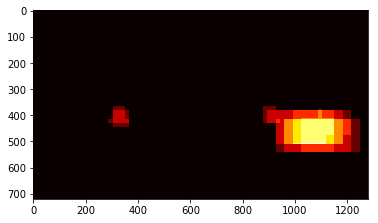

In [37]:
image = mpimg.imread('output_images/output_image_avg_heatmap_history_image805.jpg')
plt.imshow(image, cmap='hot')

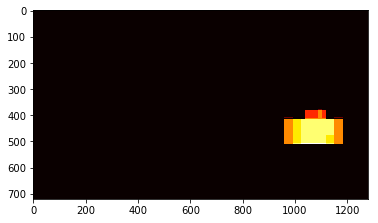

In [38]:
image = mpimg.imread('output_images/output_image_threshold_applied_image805.jpg')
plt.imshow(image, cmap='hot')

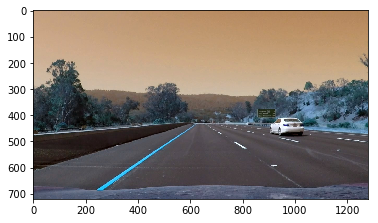

In [39]:
image = mpimg.imread('output_images/input_image805.jpg')
plt.imshow(image)

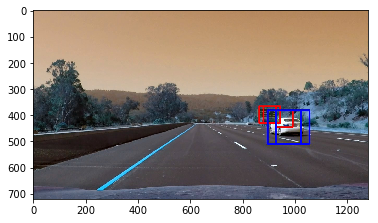

In [40]:
image = mpimg.imread('output_images/output_image_with_boxes_image805.jpg')
plt.imshow(image)

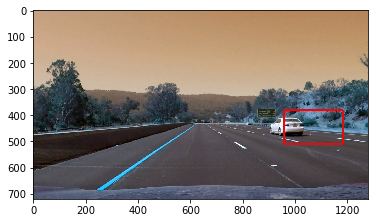

In [41]:
image = mpimg.imread('output_images/output_image805.jpg')
plt.imshow(image)